In [42]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import mdtraj as md
import pandas as pd
import yaml

import pymbar # for MBAR analysis
from pymbar import timeseries # for timeseries analysis
import seaborn as sns
import itertools
import os
from IPython.display import display, Image
import imageio
import matplotlib.colors as mcolors
import glob

with open("mpnn_config.yaml", "r") as file:
    config = yaml.safe_load(file)
upside_path = config["upside_simulation"]["upside_path"]
upside_utils_dir = os.path.expanduser(upside_path+"/py")
sys.path.insert(0, upside_utils_dir)
import mdtraj_upside as mu

def residuePerLayer(name):
    #based on protien return the number of residues per layer, left is number of residues, right is the starting residue number
    #these are the preconfigured based on previous iterations, but add your owne here
    dict = {'7YMN_5_min':(76, 303), '6h6b_6':(58, 37), 'AD9WT': (72, 306), 'AD297-391': (94,297), 'AD328-363':(36,328), 'AD335-357':(22,335), 'AD328-363_S341L_S352I':(36,328), 'AD328-363_S356L_L357S':(36,328),
            'CTE9WT': (72, 306), 'CTE297-391': (94,297), 'CTE328-363':(36,328), 'CTE335-357':(22,335), 'CTE328-363_S341L_S352I':(36,328), 'CTE328-363_S356L_L357S':(36,328),
            'AD328-363_S341A': (36,328), 'AD328-363_S352A': (36,328),'AD328-363_L357F': (36,328), 'CTE328-363_S341A': (36,328), 'CTE328-363_S352A': (36,328),'CTE328-363_L357F': (36,328),
            'AD328-363_S356L_L357S':(36,328), 'AD9_S341A_S352A_L357F':(36,328)}
    #check if the name is in the dictionary
    if name in dict:
        return dict[name]
    else:
        return (58, 37)

def plot_heatmap_grid(data_dict, width=5, title='Heatmap Grid', cmap='viridis', vmin=0, vmax=7, highlight_top_n=None):
    """
    Plot a grid of heatmaps from a dictionary of matrices.
    
    Parameters:
    -----------
    data_dict : dict
        Dictionary with names as keys and matrices as values
    width : int
        Number of plots per row
    title : str
        Title for the overall figure
    cmap : str
        Colormap to use for heatmaps
    vmin : float
        Minimum value for colormap scaling
    vmax : float
        Maximum value for colormap scaling
    """
    if not data_dict:
        print("No data to plot - empty dictionary provided")
        return
        
    height = len(data_dict)//width + 1
    
    plt.figure(figsize=(20,20))
    
    matrix_values = []
    for i, (name, matrix) in enumerate(data_dict.items()):
        plt.subplot(height, width, i+1)
        sns.heatmap(matrix, cmap=cmap, vmax=vmax, vmin=vmin)
        plt.title(os.path.basename(name))
        plt.axis('off')
        matrix_values.append(matrix.flatten())
    #if highlight_top_n is not None, highlight the top n values by drawing a red rectangle around them
    if highlight_top_n is not None:
        # Find indices of top n matrices with lowest values
        matrix_means = [np.mean(m) for m in matrix_values]
        # Calculate contrast/concentration of signal for each matrix
        matrix_contrasts = []
        for matrix in matrix_values:
            # Reshape back to 2D
            matrix = matrix.reshape(-1, int(np.sqrt(len(matrix))))
            
            # Calculate mean value
            mean_value = np.mean(matrix)
            
            # Calculate signal concentration using ratio of low values
            threshold = np.percentile(matrix, 25)  # Bottom 25% threshold
            signal_concentration = np.sum(matrix < threshold) / matrix.size
            
            # Combined score favoring low mean and concentrated signal
            contrast_score = mean_value * signal_concentration
            matrix_contrasts.append(contrast_score)
            
        # Sort by contrast score to get lowest values first
        matrix_means = matrix_contrasts
        top_n_indices = np.argsort(matrix_means)[:highlight_top_n]
        
        # Add red rectangle border around the top n subplots
        for idx in top_n_indices:
            plt.subplot(height, width, idx+1)
            plt.gca().spines['bottom'].set_color('red')
            plt.gca().spines['top'].set_color('red') 
            plt.gca().spines['right'].set_color('red')
            plt.gca().spines['left'].set_color('red')
            plt.gca().spines['bottom'].set_linewidth(2)
            plt.gca().spines['top'].set_linewidth(2)
            plt.gca().spines['right'].set_linewidth(2)
            plt.gca().spines['left'].set_linewidth(2)
            #set the middle of the rectangle transparent
            plt.gca().set_facecolor('none')

    plt.tight_layout()
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.subplots_adjust(top=0.95)
    plt.show()


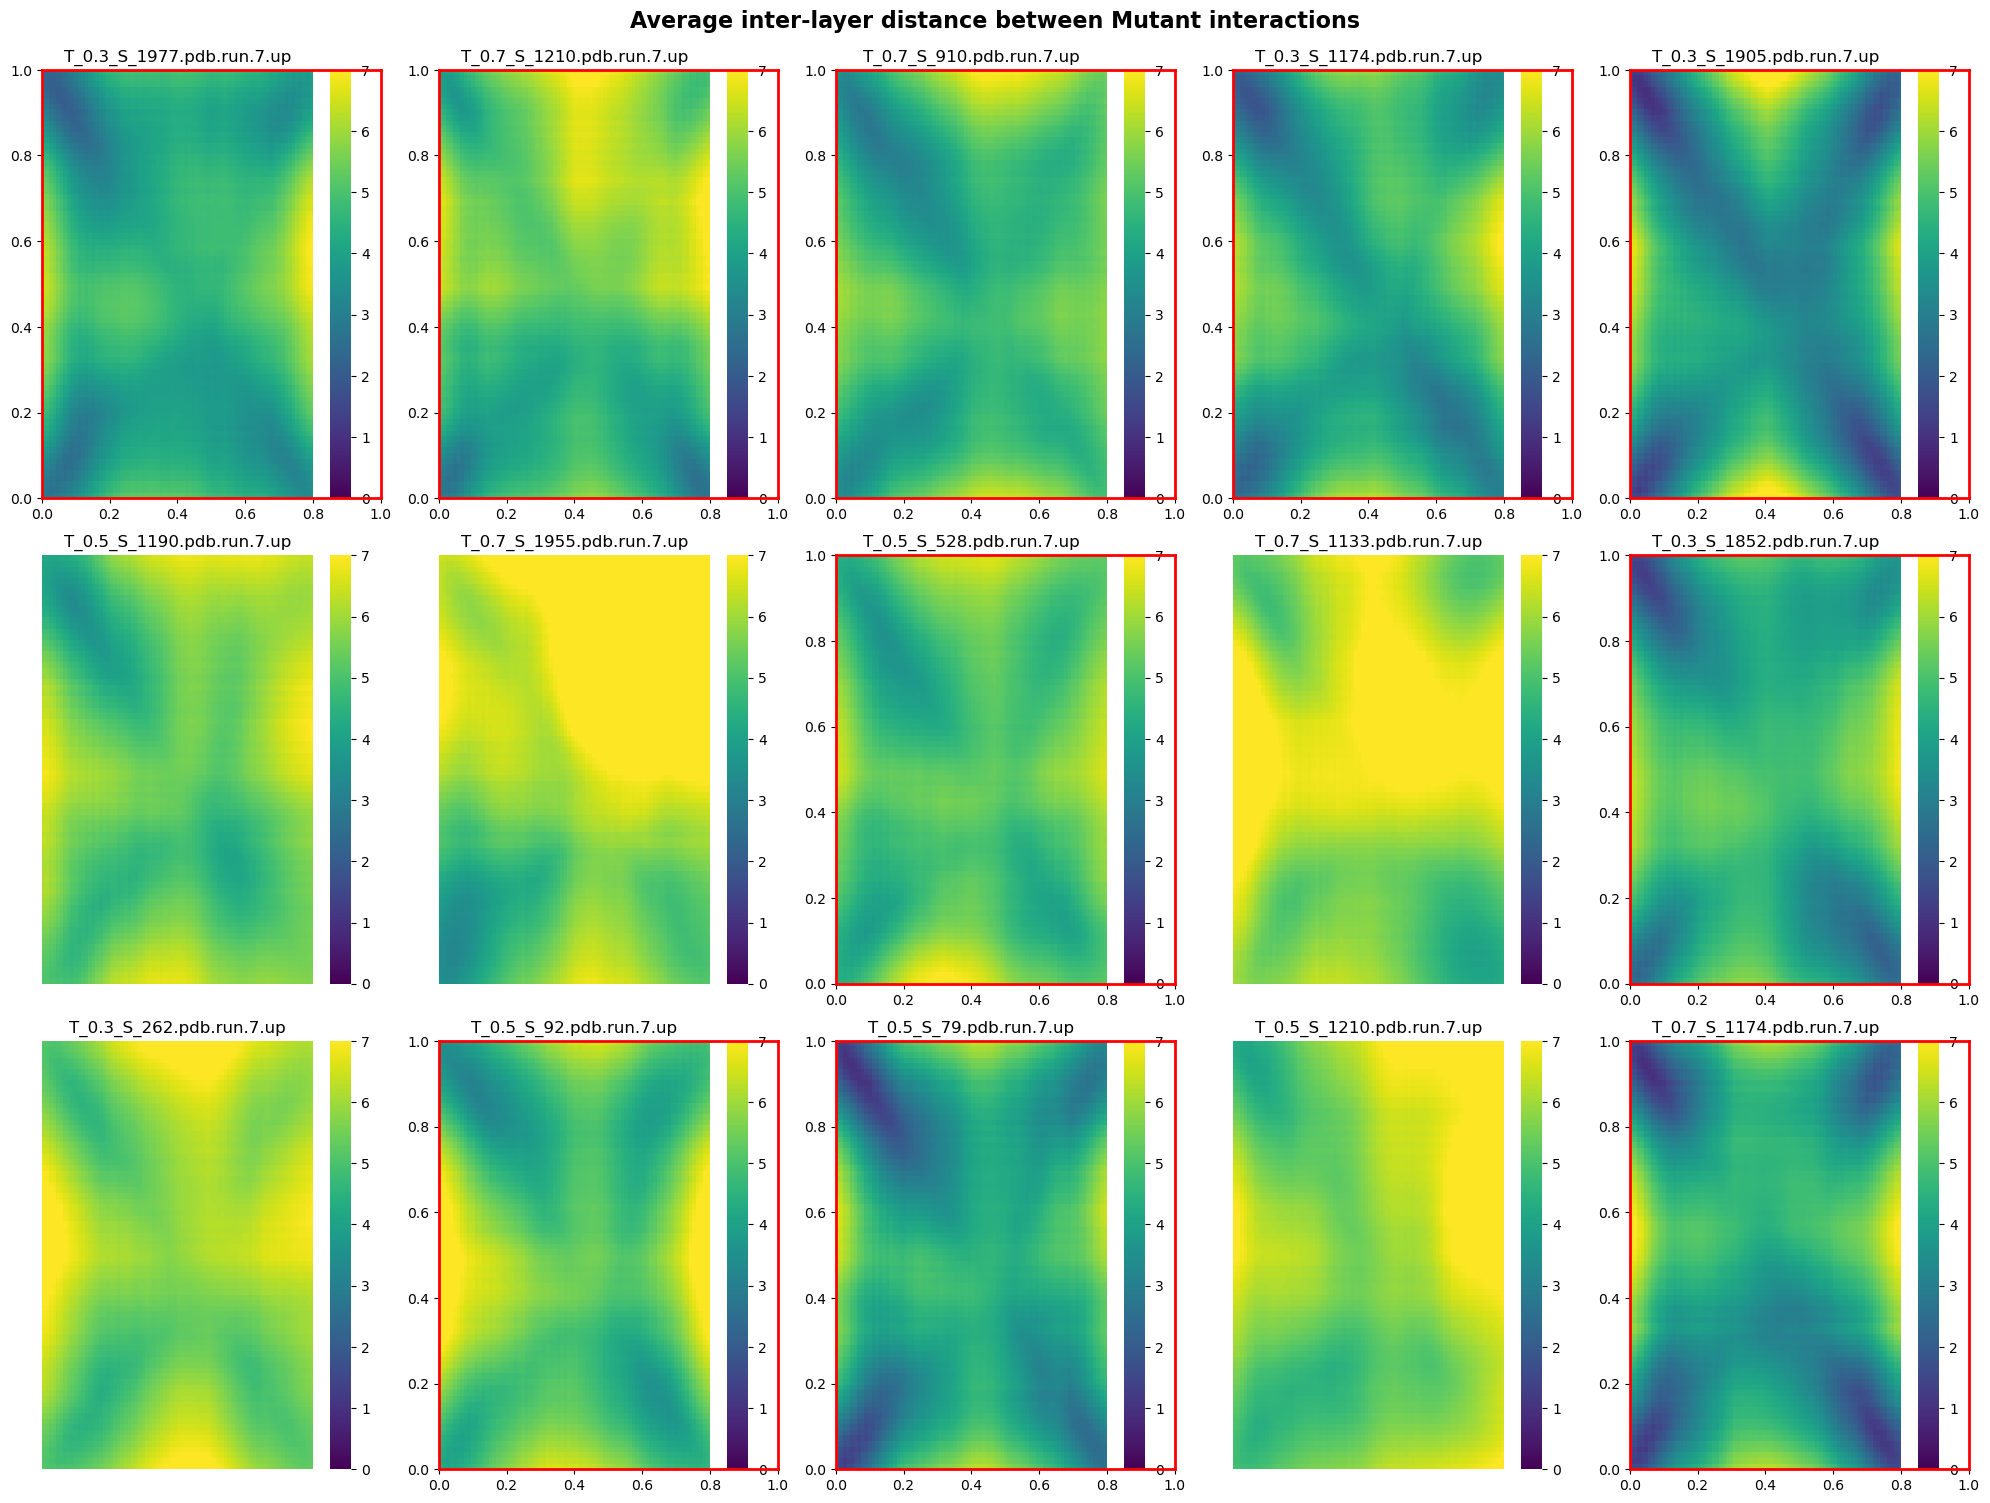

In [43]:
def interLayerDistanceHeatmap(file, protein, layerA=1):
    """
    Create a heatmap of distances between residues in two adjacent layers
    
    Parameters:
    -----------
    folder : str
        Path to the simulation folder
    protein : str 
        Name of the protein
    run : int
        Run number
    simulation : str
        Name of simulation folder
    layerA : int
        First layer number (second layer will be layerA+1)
    """
    path = os.getcwd()
    traj = mu.load_upside_traj(file)
    
    # Get number of residues per layer
    residues_per_layer = residuePerLayer(protein)[0]
    
    # Select CA atoms for both layers
    layer1_start = (layerA-1) * residues_per_layer
    layer1_end = layerA * residues_per_layer
    layer2_start = layer1_end 
    layer2_end = layer2_start + residues_per_layer
    
    layer1_CA = traj.top.select(f'resid {layer1_start} to {layer1_end-1} and name CA')
    layer2_CA = traj.top.select(f'resid {layer2_start} to {layer2_end-1} and name CA')
    # Create all pairs between layers
    atom_pairs = []
    for atom1 in layer1_CA:
        for atom2 in layer2_CA:
            atom_pairs.append([atom1, atom2])
            
    # Calculate distances
    distances = md.compute_distances(traj, atom_pairs)
    
    # Average over frames
    avg_distances = np.mean(distances, axis=0)
    
    # Reshape into matrix for heatmap
    distance_matrix = avg_distances.reshape(len(layer1_CA), len(layer2_CA))
    
    return distance_matrix

#inter-region distance heatmap, comparing the distance between two layers of a fibril, aka how fast does it separate between layers1 and 2

#the higher the run the higher the temperature, therefore deeper colors means more stable regions
run = 7
protein_name = "7YMN_5_min"
Simulation = "Simulation1"
folder = f"{config['upside_simulation']['output_path']}/{protein_name}/Simulations/outputs/{Simulation}"


# Get list of files
files = glob.glob(f"{folder}/*run.{run}.up")

if len(files) == 0:
    print(f"No files found matching pattern: {folder}/outputs/*run.{run}.up")
    print("Please check the folder path and file pattern")
else:
   
    # Calculate distance matrices
    avg_dis = {}
    for i, file in enumerate(files):
        try:
            file_name = file.split("/")[-1].split(".run")[0]
            avg_dis[file] = interLayerDistanceHeatmap(file, protein_name, layerA=2)
        except Exception as e:
            print(f"Error processing file {file}: {str(e)}")
    
    # Plot using the new function, highlight top n shows the top 10 with the lowest average distance by higlighting with a red rectangle but you can
    #leave it blank to not highlight
    plot_heatmap_grid(avg_dis, title='Average inter-layer distance between Mutant interactions', highlight_top_n=10)


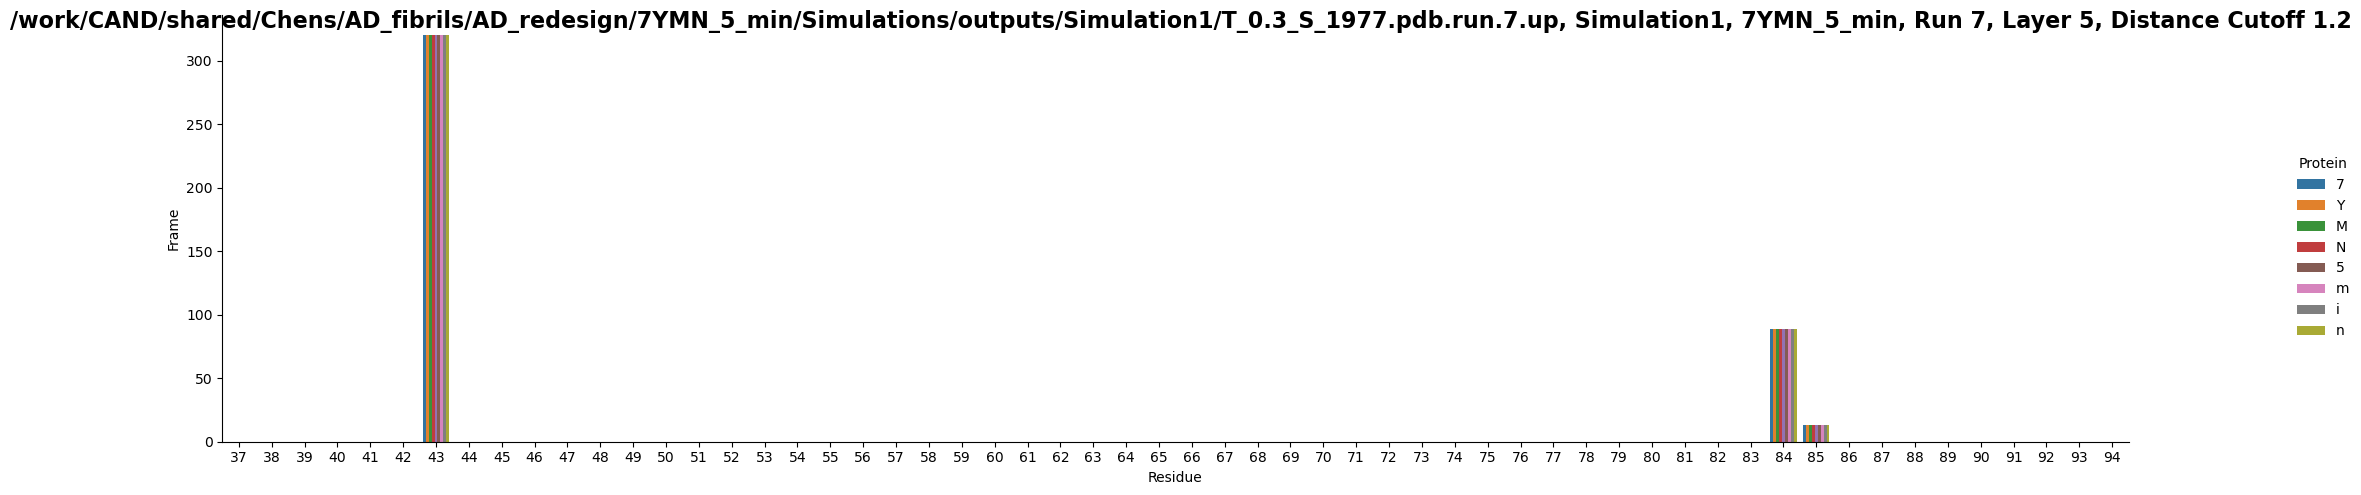

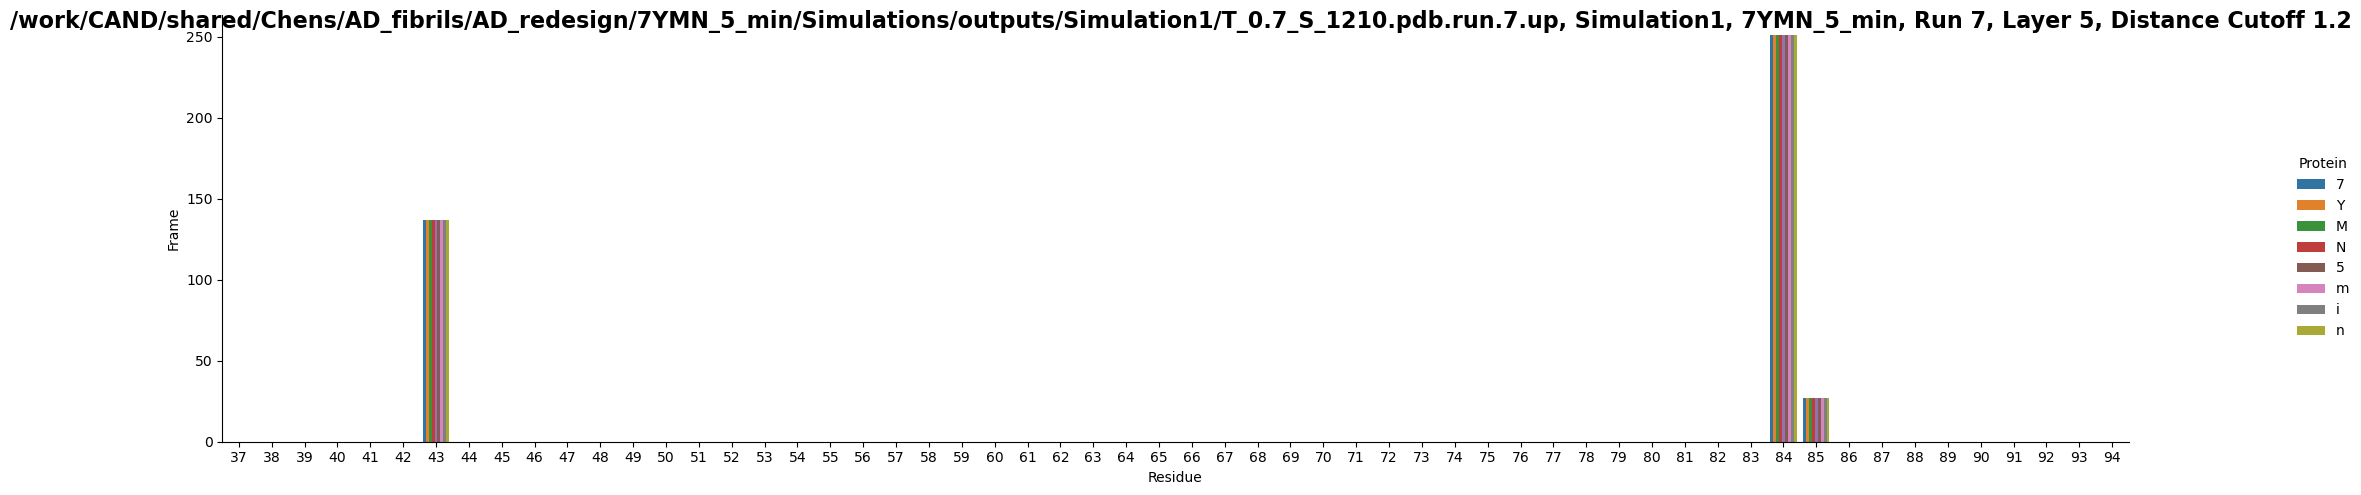

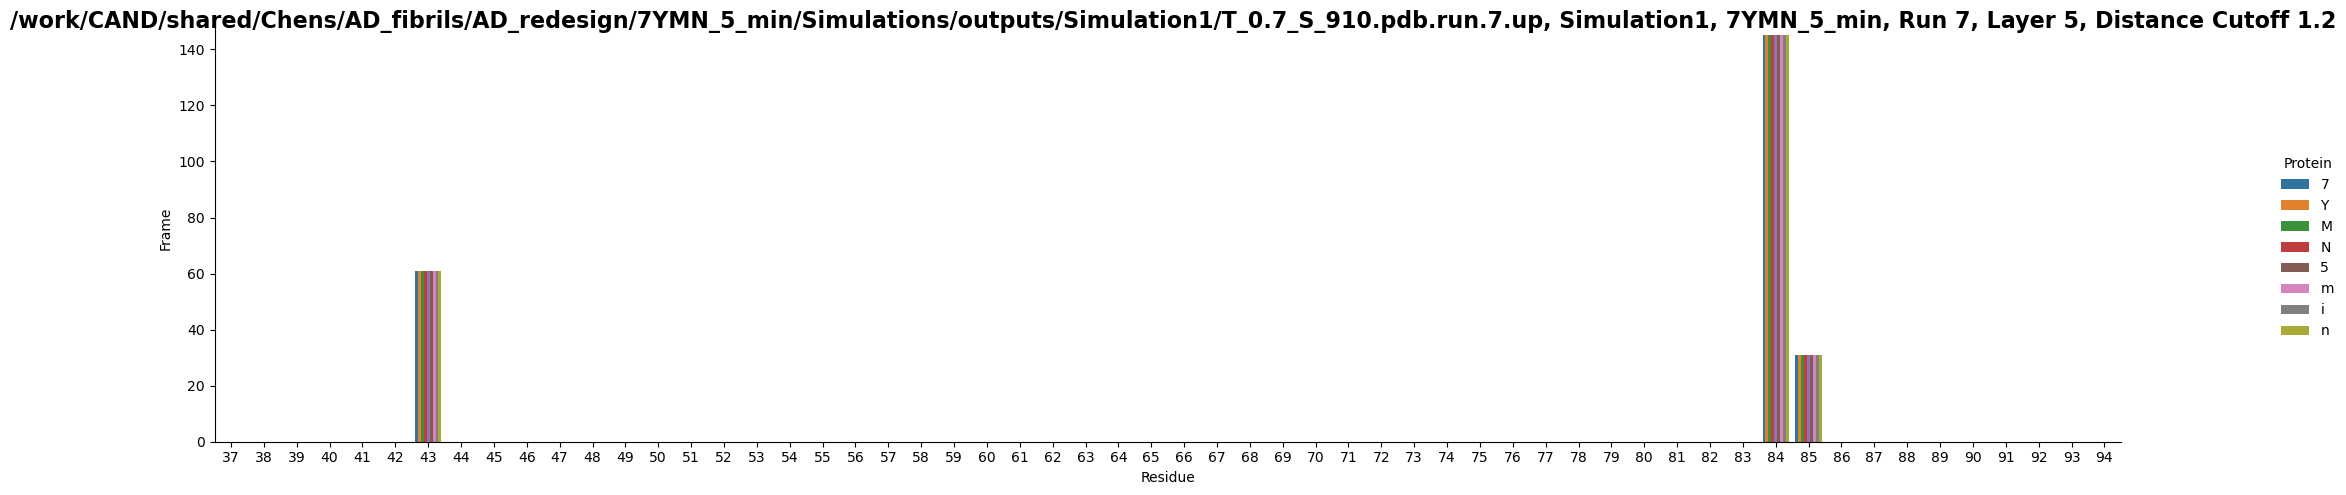

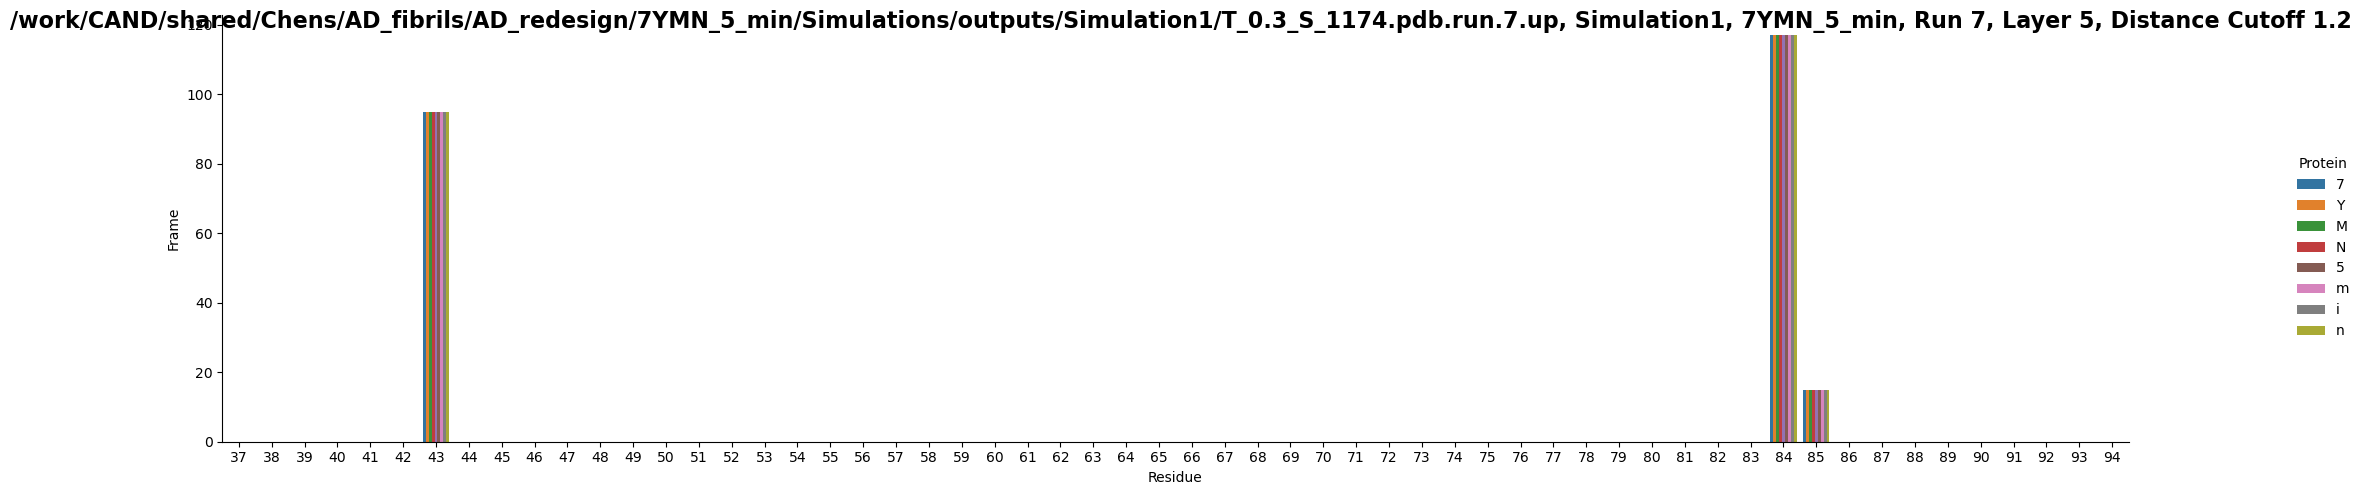

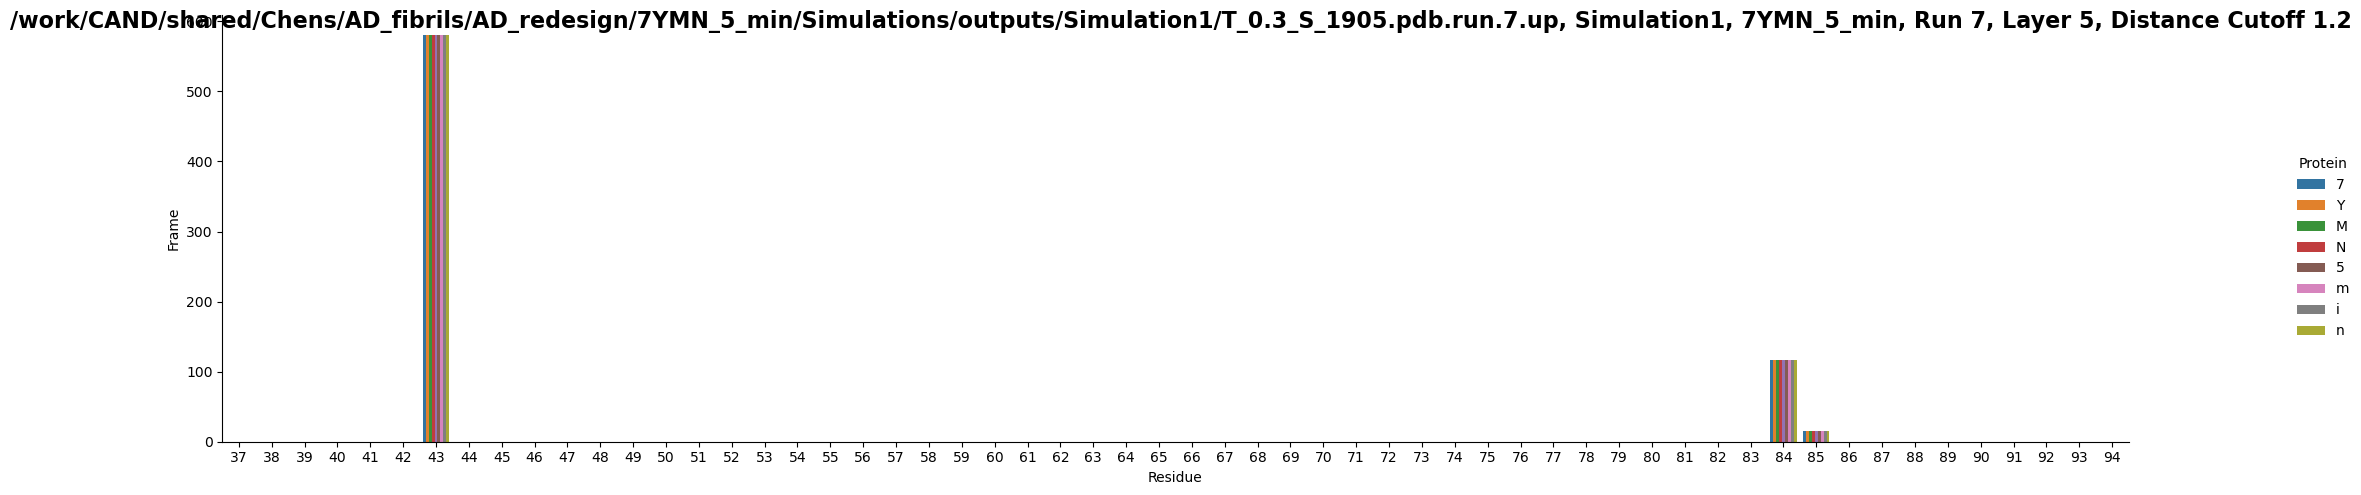

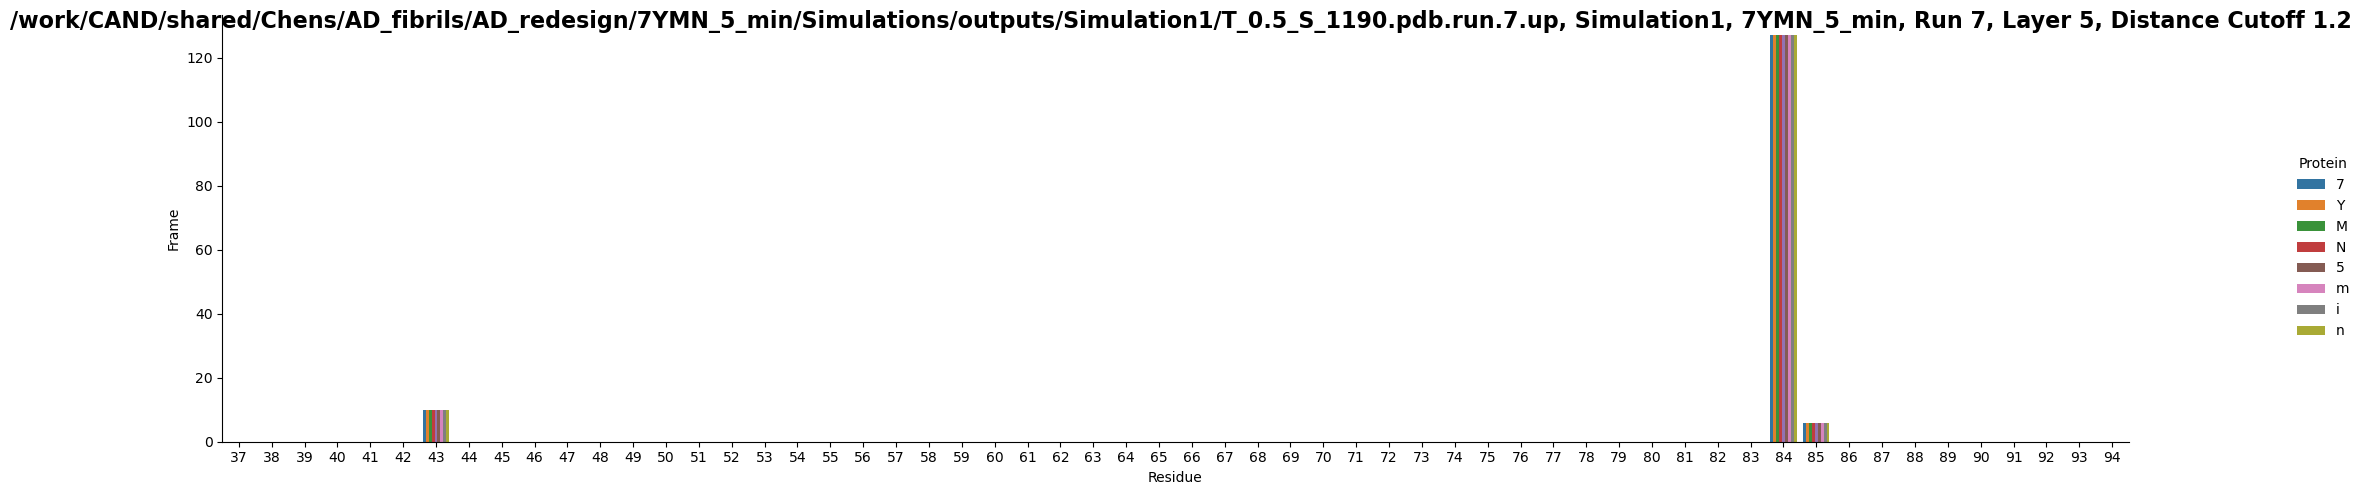

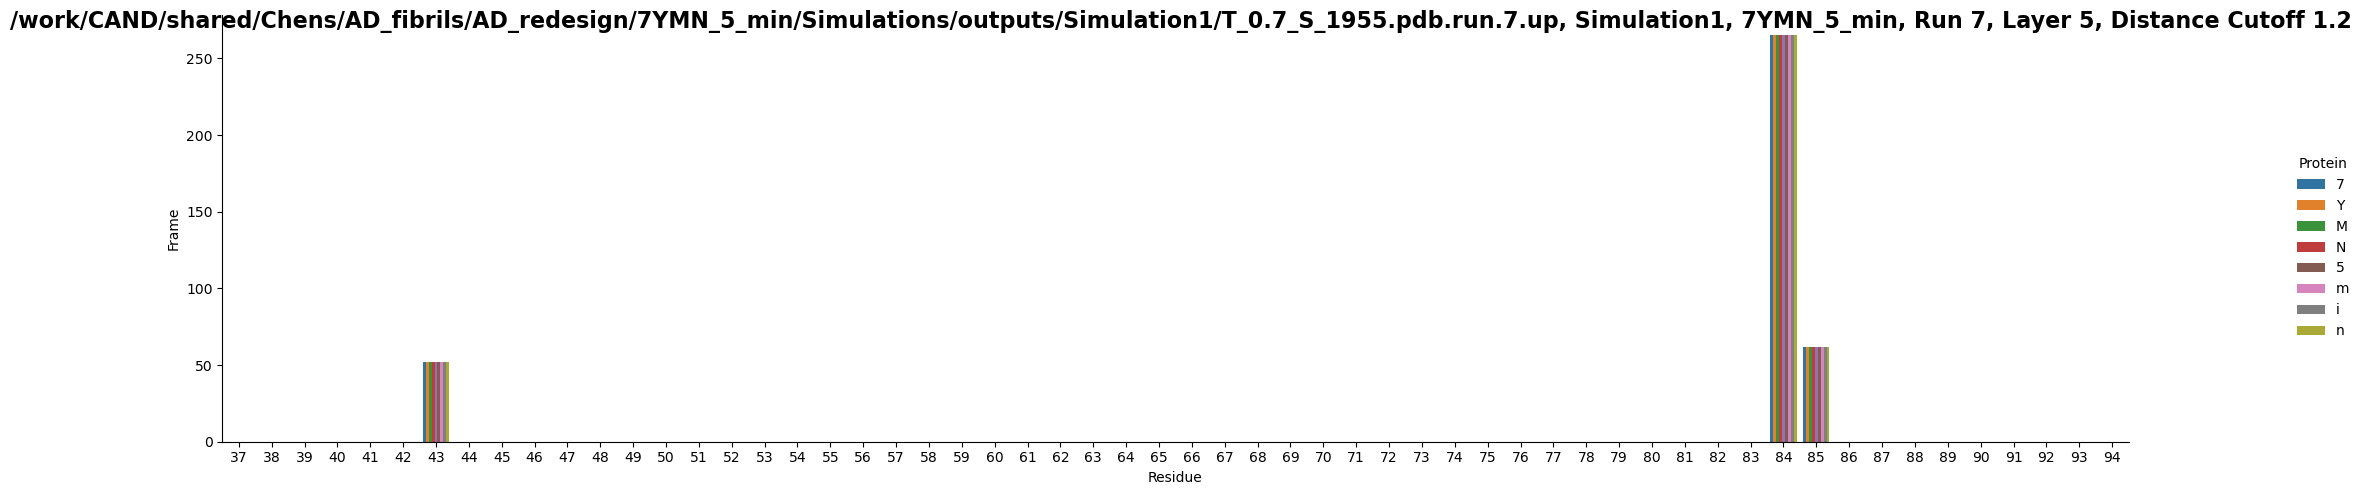

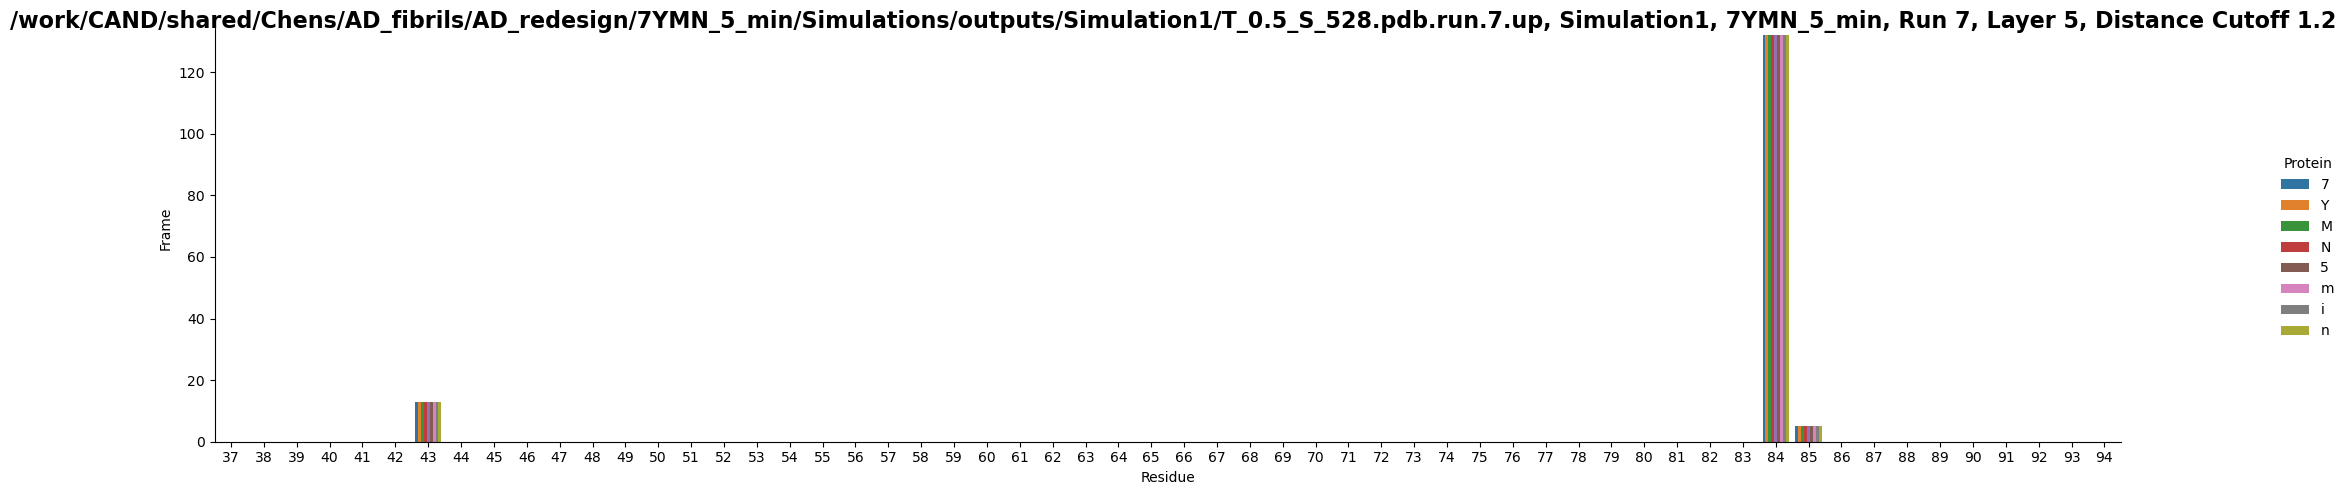

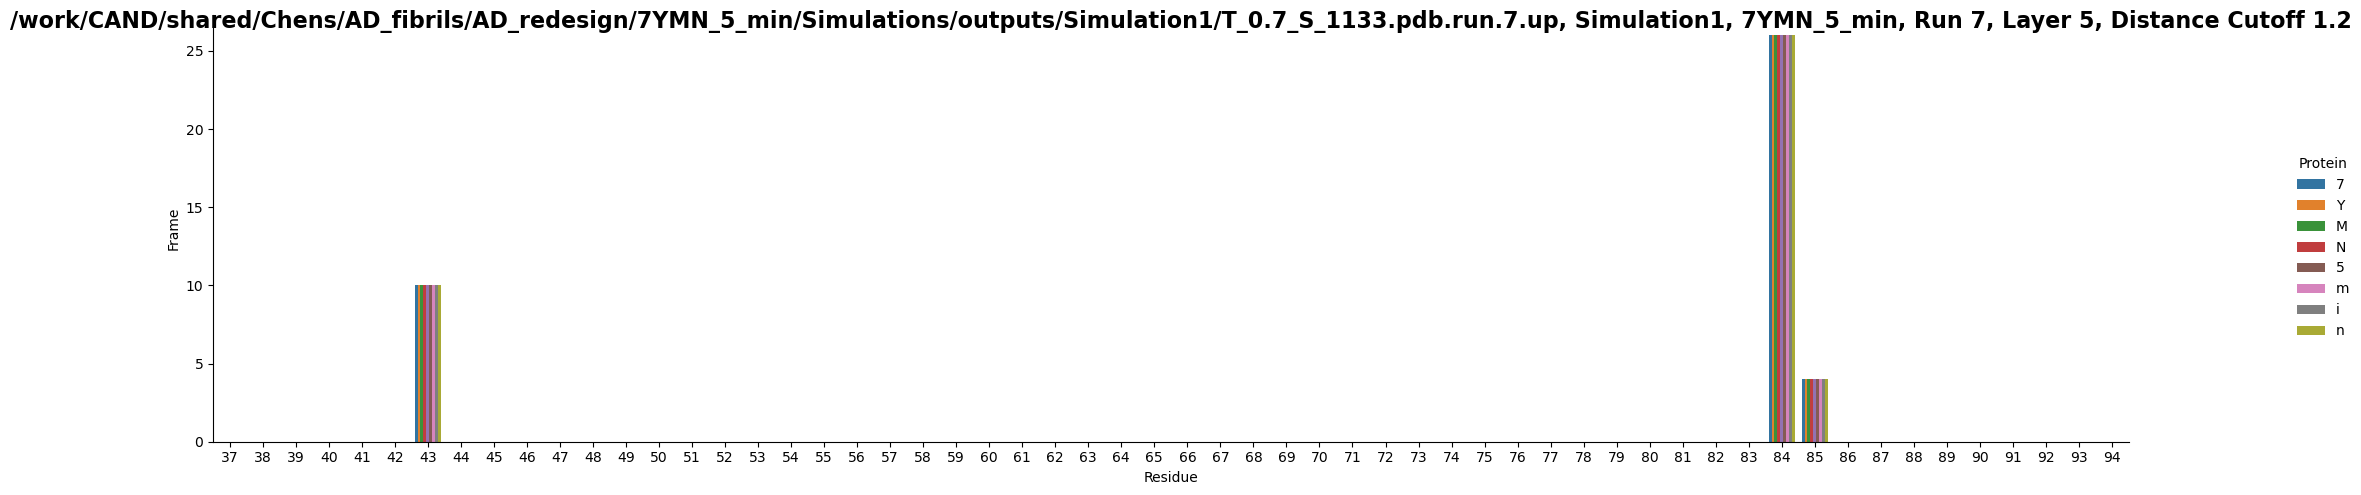

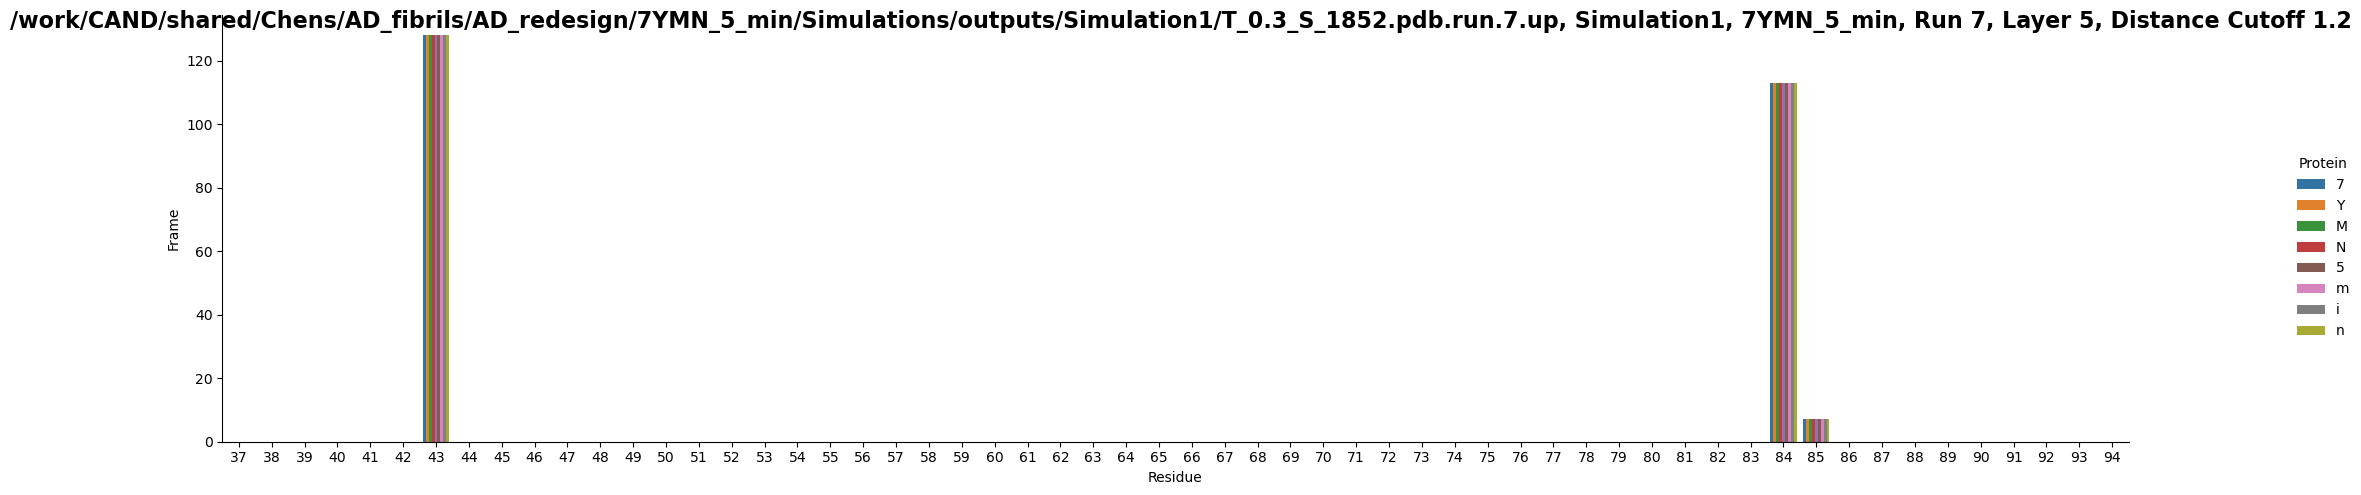

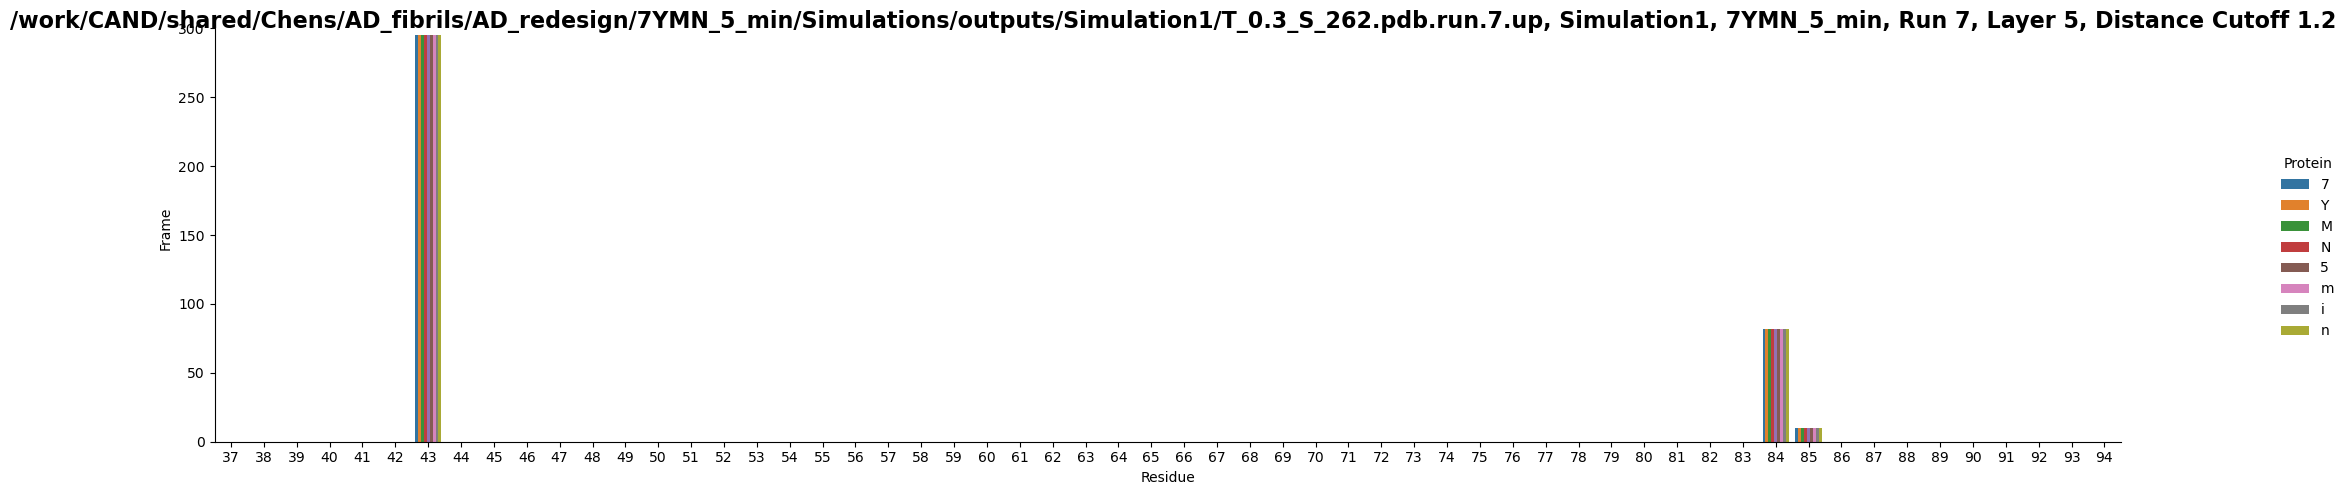

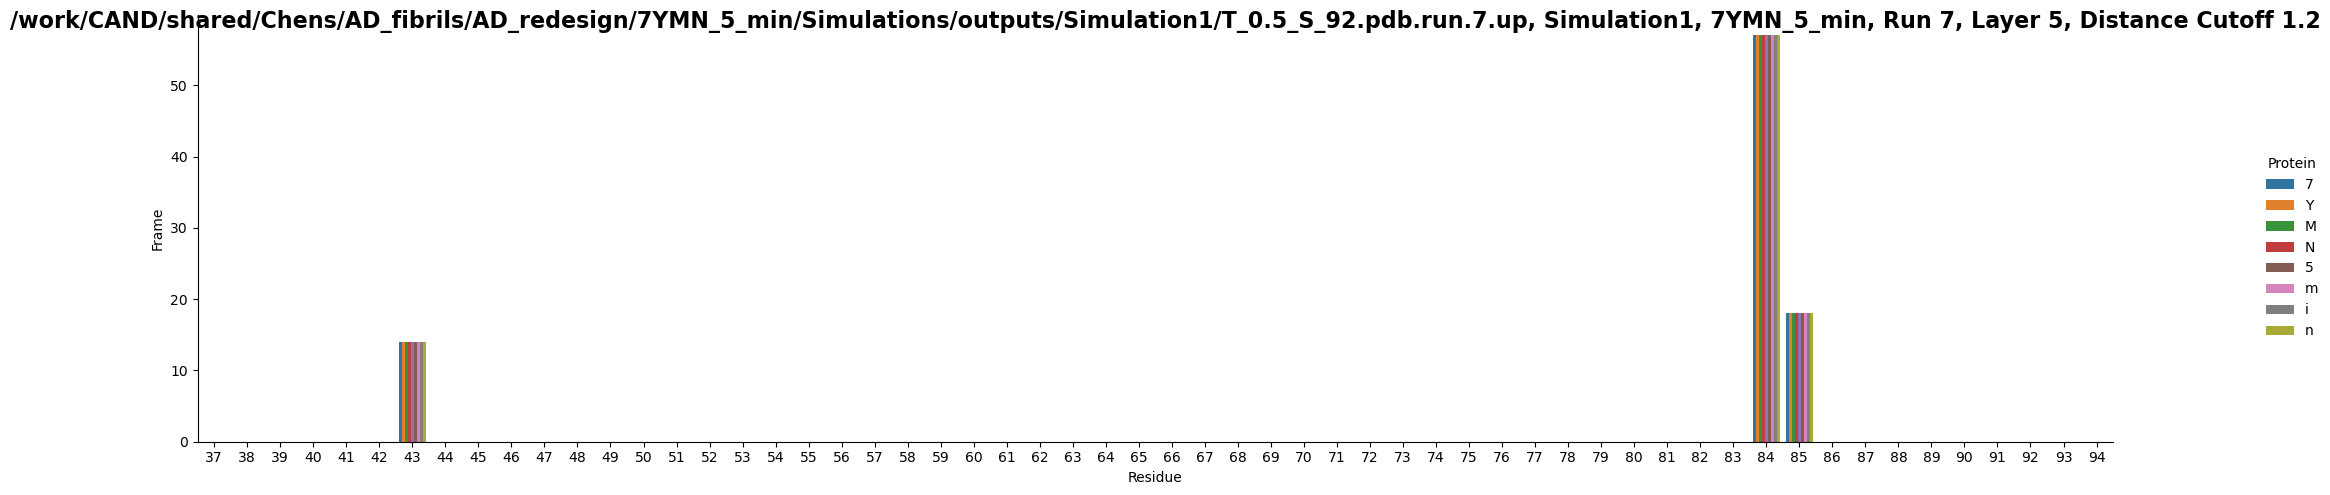

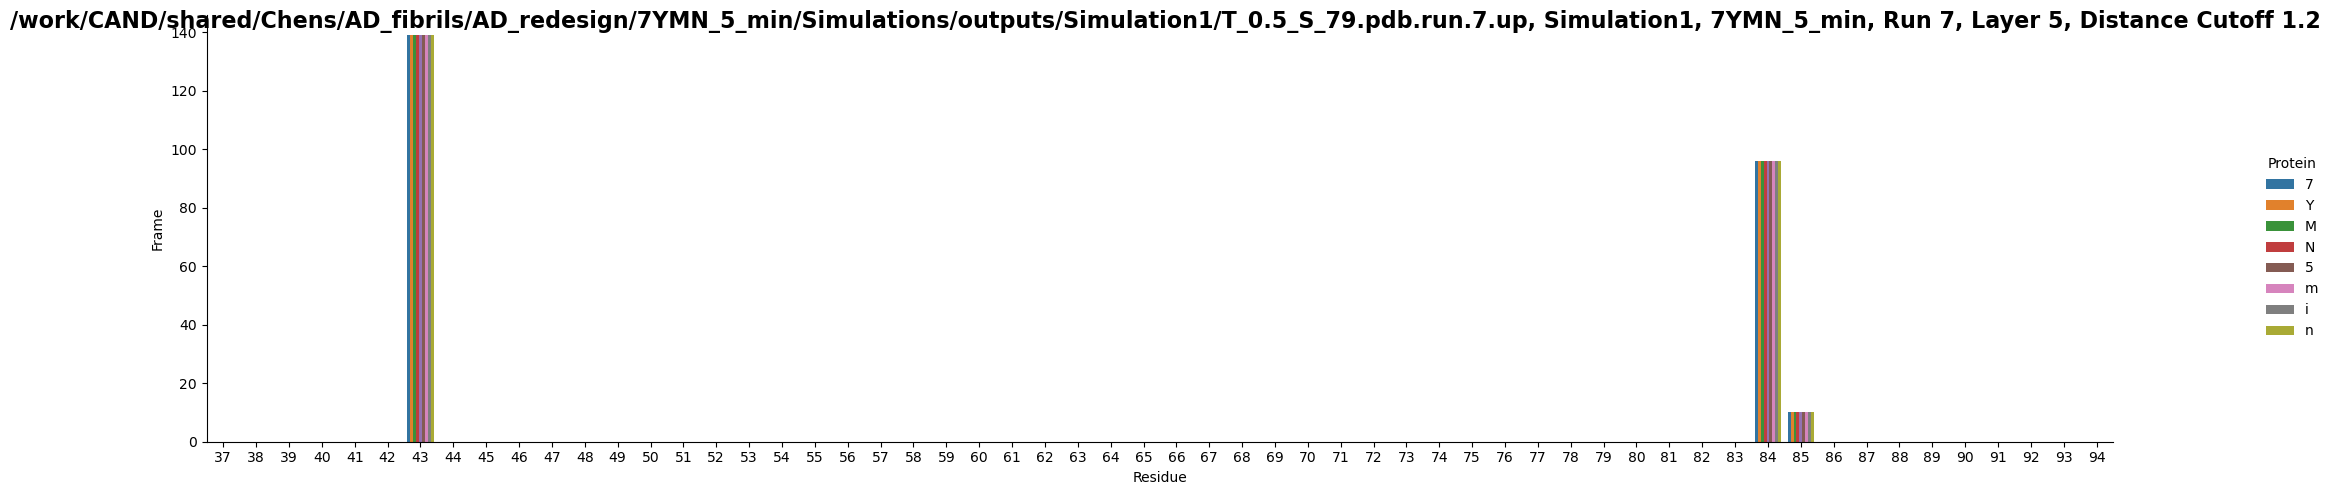

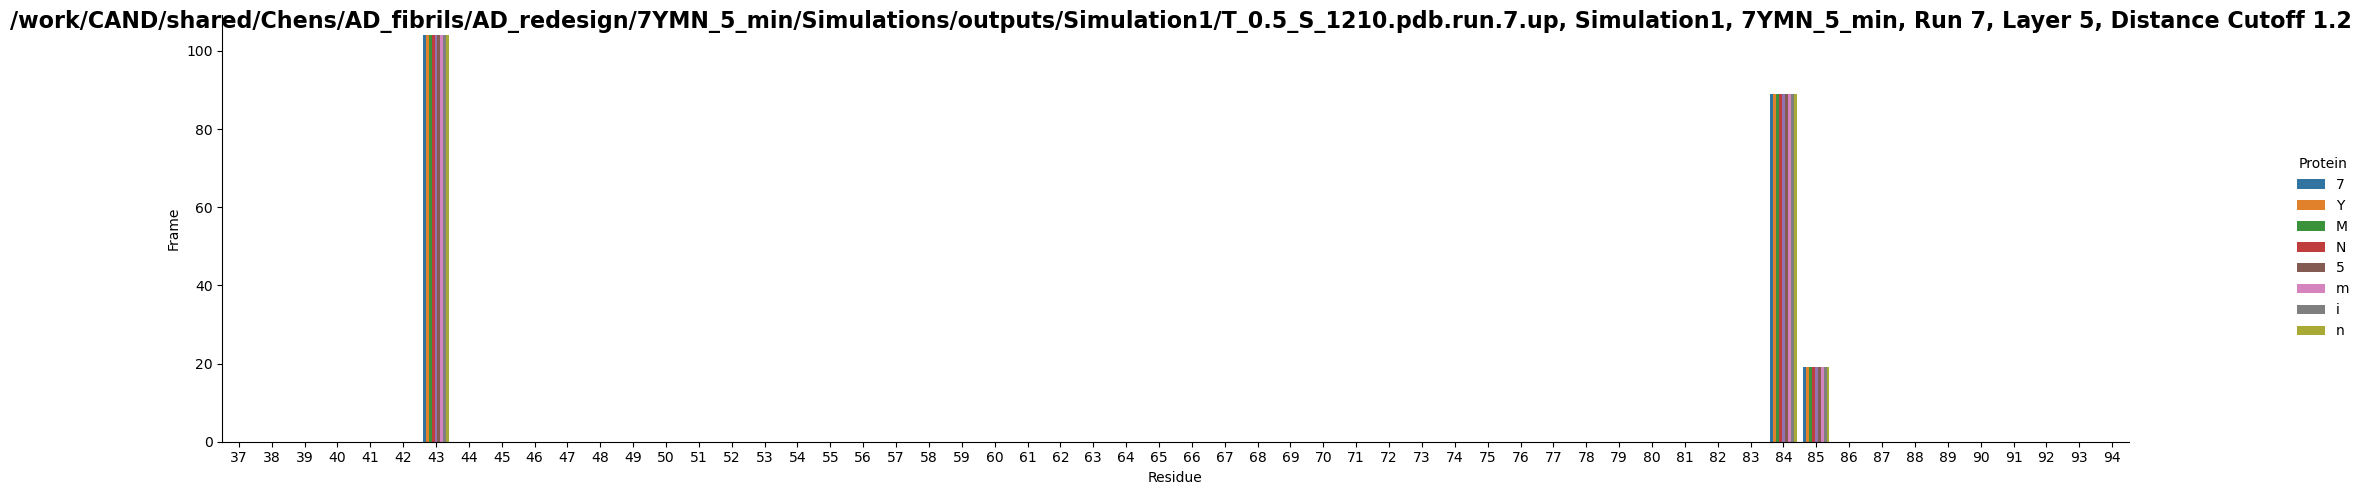

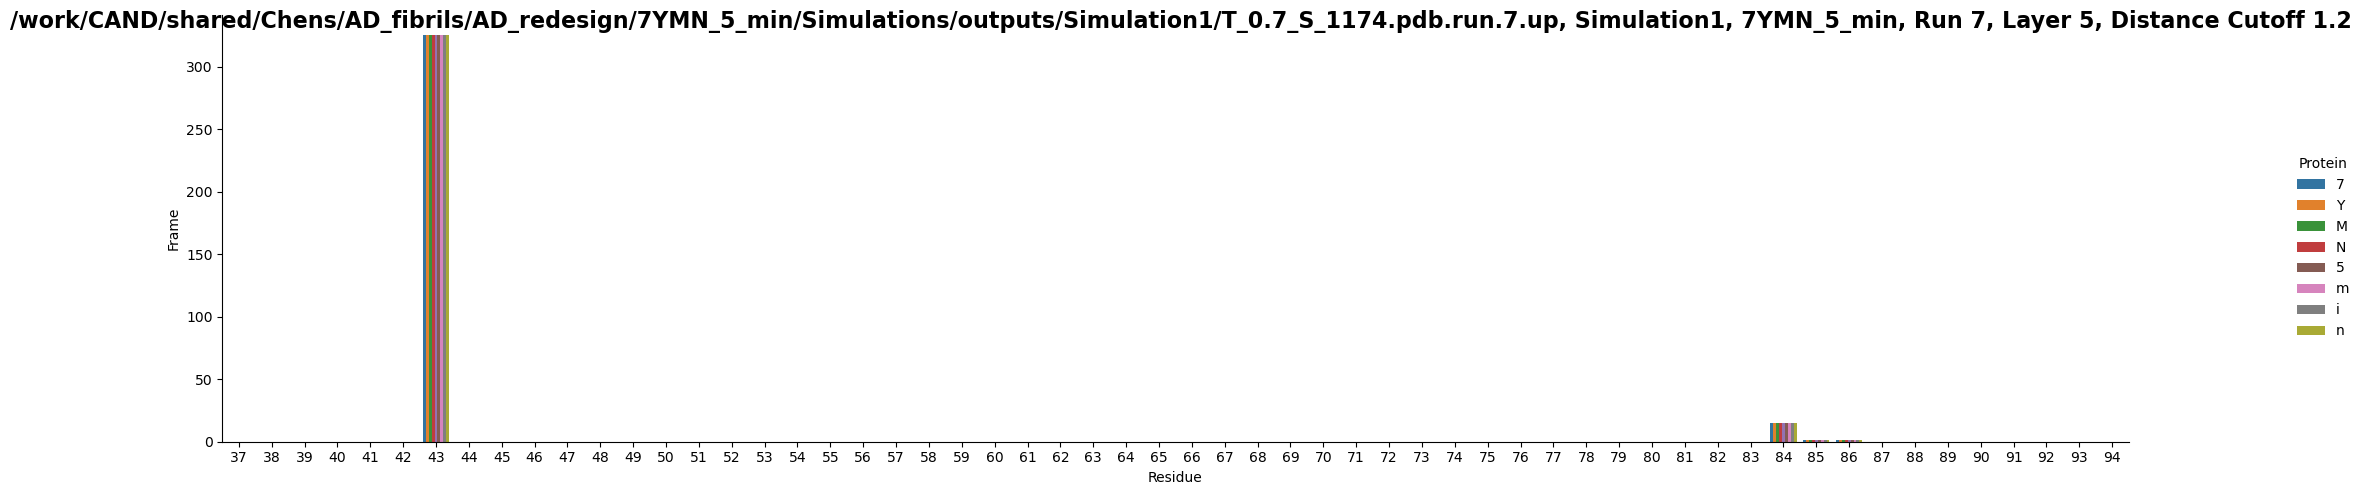

In [29]:
def layerResiPairDistanceBarGraph(folder, simulations,proteins, run, layerA=1, distanceCutoff=5):
    """
    Create a bar graph of the distance between residue pairs within a layer of a protein for all simulations
    Grey bars when the residue doens't exceed the distance cutoff
    """
    pal = sns.color_palette("rocket", len(proteins))
    proteinData = pd.DataFrame(columns = ['Residue', 'Frame'])
    smallesStarter = 10000
    for protein in proteins:
        starter = residuePerLayer(protein)[1]
        if starter < smallesStarter:
            smallesStarter = starter
    for colorNum, protein in enumerate(proteins):
        sum = 0
        for simulation in simulations:
            #create residue pairs of a protein between layers
            #protein='AD9WT'
            #run=14
            path=os.getcwd()
            traj = mu.load_upside_traj(folder)
            residueNumber = residuePerLayer(protein)[0]
            aligningOffset = residuePerLayer(protein)[1] - smallesStarter
            chainA = list(np.arange((layerA-1)*residueNumber,(layerA)*residueNumber))
            pairs = ((i,i+residueNumber) for i in chainA)
            pairs = list(pairs)
            atomList=[]
            for pair in pairs:
                #find the CA atoms for each residue in pair
                atomA = traj.top.select('residue {} and name CA'.format(pair[0]))
                atomB = traj.top.select('residue {} and name CA'.format(pair[1]))
                #check that atomA and atomB are not empty
                if atomA and atomB:
                    atomList.append((atomA[0], atomB[0]))
            #check size of pairs
            distanceList = np.array(md.compute_distances(traj, atomList, periodic=True))
            sum = np.add(sum, distanceList)
        sum = sum/len(simulations)
        pairDict = {}
        for num, pair in enumerate(pairs):
            pairDict[num] = 1000
            for frame, distance in enumerate(sum):
                if distance[num] > distanceCutoff:
                    pairDict[num] = frame
                    break
        #concatenate the data to parent dataframe
        aligningOffset=residuePerLayer(protein)[1]
        #add offset to the residue number
        pairDict = {k+aligningOffset:v for k,v in pairDict.items()}
        proteinData = pd.concat([proteinData,pd.DataFrame({'Residue': list(pairDict.keys()), 'Frame': list(pairDict.values()), 'Protein':protein})])
        
    g = sns.catplot(x='Residue', y='Frame', hue='Protein', data=proteinData, height=5, kind='bar',aspect=4)
    #color the bar gray if the frame is greater than 1000
    for patch in g.ax.patches:
        if patch.get_height() >= 1000:
            patch.set_facecolor('gray')
    #set titlt to folder, bold
    g.figure.suptitle(f"{folder}, {simulations}, {proteins}, Run {run}, Layer {layerA}, Distance Cutoff {distanceCutoff}", fontsize=16, fontweight='bold')
    
    #g.set(ylim=(0, 800))
    #plot the data frame using categorical bar graph using axes
    
    #set title


for file in files:
    layerResiPairDistanceBarGraph(file, Simulation, protein_name, run, layerA=5, distanceCutoff=1.2)

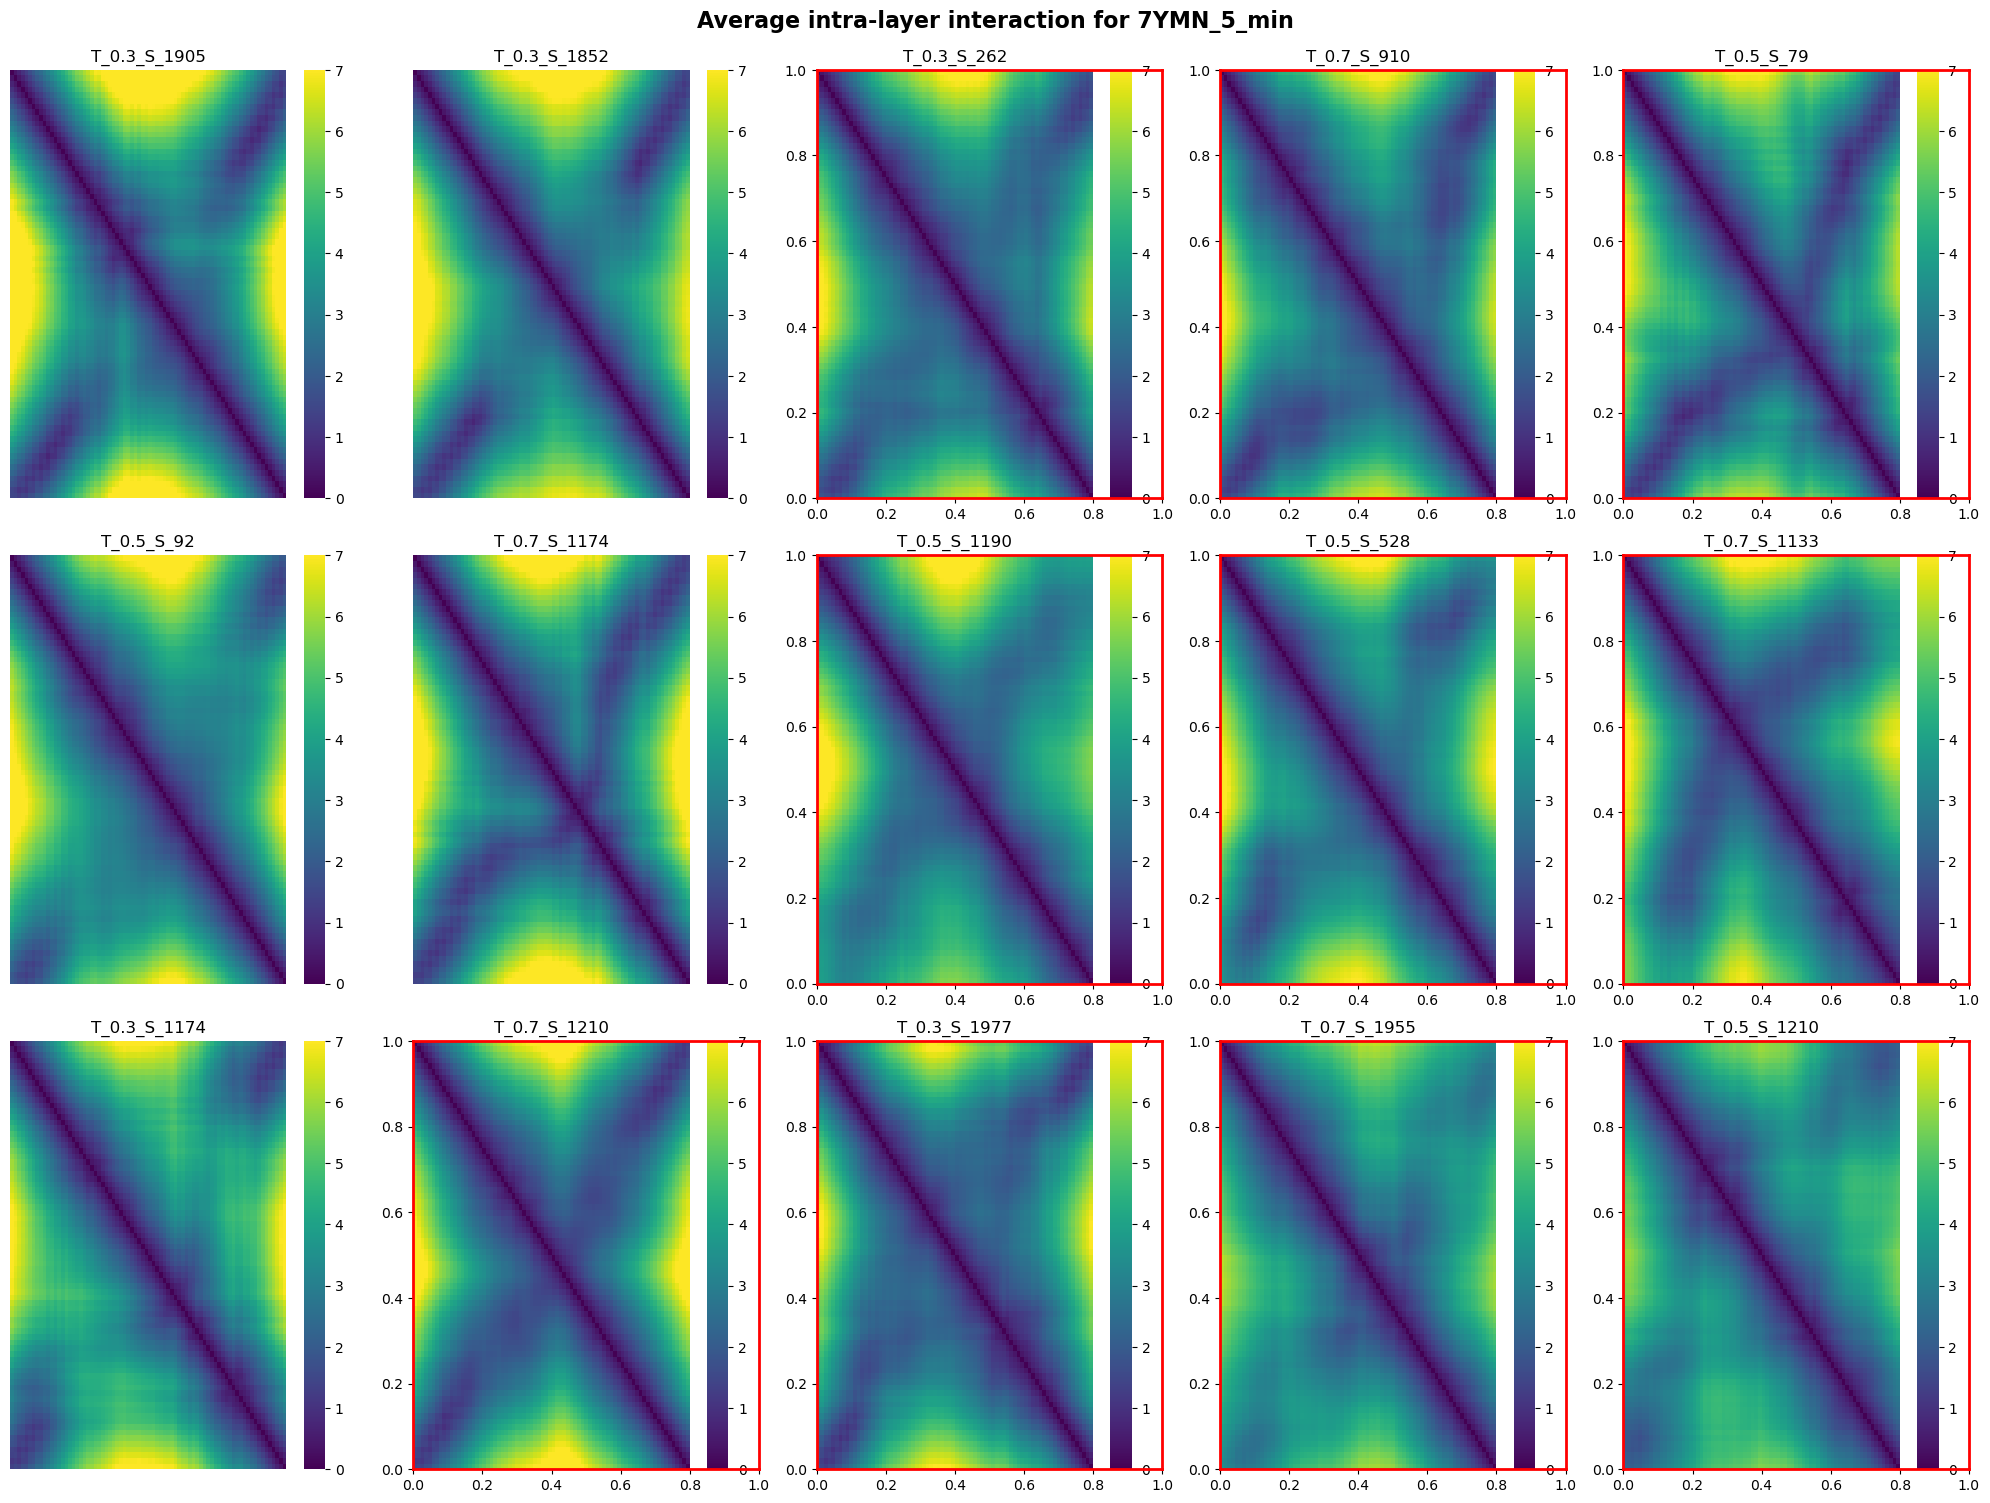

In [44]:

def avgIntraLayerInterationHeatmap(file, protein, run, simulations,startlayer=0,endlayer=8, startFrame=200, endFrame=400):
    #create a heatmap with the average interactions between residues within a layer of a protein for all layers
    residueNumber = residuePerLayer(protein)[0]
    shiftedNumber = residuePerLayer(protein)[1]
    results = np.zeros(((endFrame-startFrame), residueNumber, residueNumber))

    
    for layer in range(startlayer, endlayer):
        #select the residues in the layer
        avgResult=0
        for simulation in simulations:
            traj = mu.load_upside_traj(file)
            layerResidues = np.arange((layer-1)*residueNumber,(layer)*residueNumber)
            #select the CA atoms for the residues
            atomList = []
            for residue in layerResidues:
                atom = traj.top.select('residue {} and name CA'.format(residue))
                if atom:
                    atomList.append(atom[0])
            #create pairs using layerResidues
            pairs = list(itertools.combinations(layerResidues, 2))
            distance, pair = md.compute_contacts(traj[startFrame:endFrame], contacts=pairs, scheme='ca', periodic=True)
            map = np.array(md.geometry.squareform(distance,pair))
            results = results + map[:, -residueNumber:, -residueNumber:]
            avgResult = avgResult + map[:, -residueNumber:, -residueNumber:]
        avgResult = avgResult/len(simulations)
    results = avgResult/(endlayer-startlayer)

    #plot the heatmap
    # plt.figure(figsize=(12, 8))
    summed_matrix = np.sum(results, axis=0)/(endFrame-startFrame)
    # cmap = mcolors.LinearSegmentedColormap.from_list("custom_orange", 
    #                                              ["black", "red","#FFA500","white"])
    # sns.heatmap(summed_matrix, cmap=cmap, xticklabels=np.arange(shiftedNumber,residueNumber+shiftedNumber), yticklabels=np.arange(shiftedNumber,residueNumber+shiftedNumber), vmax=3.5)
    # plt.title(f'{folder} Layer {startlayer} IntraLayer Interaction for {protein} run {run} Frames {startFrame} - {endFrame}')
    return summed_matrix
    #save png
    #plt.savefig(f'Layer_{startlayer}_IntraLayer_Interaction_{protein}_run_{run}_simulation_{simulation}_Frames_{startFrame}_{endFrame}.png')

#this for loop produces heatmaps containing the average of every 100 frames
"""for frames in range(200,1000,100):
    avgIntraLayerInterationHeatmap('CTE-ReplicaExchange','CTE328-363', 7, 'Simulation1',startlayer=2,endlayer=3,startFrame=frames-100, endFrame=frames)
"""
#the layers can be averaged through many layers or only the select startlayer
#avgIntraLayerInterationHeatmap('CTE-ReplicaExchange','CTE328-363', 7, ['Simulation1','Simulation2','Simulation3'],startlayer=2,endlayer=3,startFrame=200, endFrame=300)

#the layers can be averaged through many layers or only the select startlayer
#avgIntraLayerInterationHeatmap('CTE-ReplicaExchange','CTE328-363', 7, ['Simulation1','Simulation2','Simulation3'],startlayer=2,endlayer=3,startFrame=200, endFrame=300)
files = [file for file in os.listdir('/work/CAND/shared/Chens/AD_fibrils/AD_redesign/7YMN_5_min/top_N_fibrils')]
total_matrix = {}
for file in files:
    file_name = file.split('.p')[0]
    total_matrix[file_name] = avgIntraLayerInterationHeatmap(f"/work/CAND/shared/Chens/AD_fibrils/AD_redesign/7YMN_5_min/Simulations/outputs/Simulation1/{file_name}.pdb.run.7.up", '7YMN_5_min', 7,['Simulation1'], startlayer=2,endlayer=3,startFrame=300, endFrame=400)
#pass this to the plot_heatmap_grid function
plot_heatmap_grid(total_matrix, title='Average intra-layer interaction for 7YMN_5_min', highlight_top_n=10)


Calculating the interLayer change over all simulations

<mdtraj.Trajectory with 1001 frames, 2220 atoms, 380 residues, without unitcells>
   Residue           Protein  Simulation1
0      266  T_0.3_S_1905.pdb          0.0
1      267  T_0.3_S_1905.pdb          0.0
2      268  T_0.3_S_1905.pdb          0.0
3      269  T_0.3_S_1905.pdb          0.0
4      270  T_0.3_S_1905.pdb          0.0
..     ...               ...          ...
71     337  T_0.3_S_1905.pdb          0.0
72     338  T_0.3_S_1905.pdb          0.0
73     339  T_0.3_S_1905.pdb          0.0
74     340  T_0.3_S_1905.pdb          0.0
75     341  T_0.3_S_1905.pdb          0.0

[76 rows x 3 columns]
<mdtraj.Trajectory with 1001 frames, 2220 atoms, 380 residues, without unitcells>
   Residue           Protein  Simulation1
0      266  T_0.3_S_1905.pdb          0.0
1      267  T_0.3_S_1905.pdb          0.0
2      268  T_0.3_S_1905.pdb          0.0
3      269  T_0.3_S_1905.pdb          0.0
4      270  T_0.3_S_1905.pdb          0.0
..     ...               ...          ...
71     337  T_0

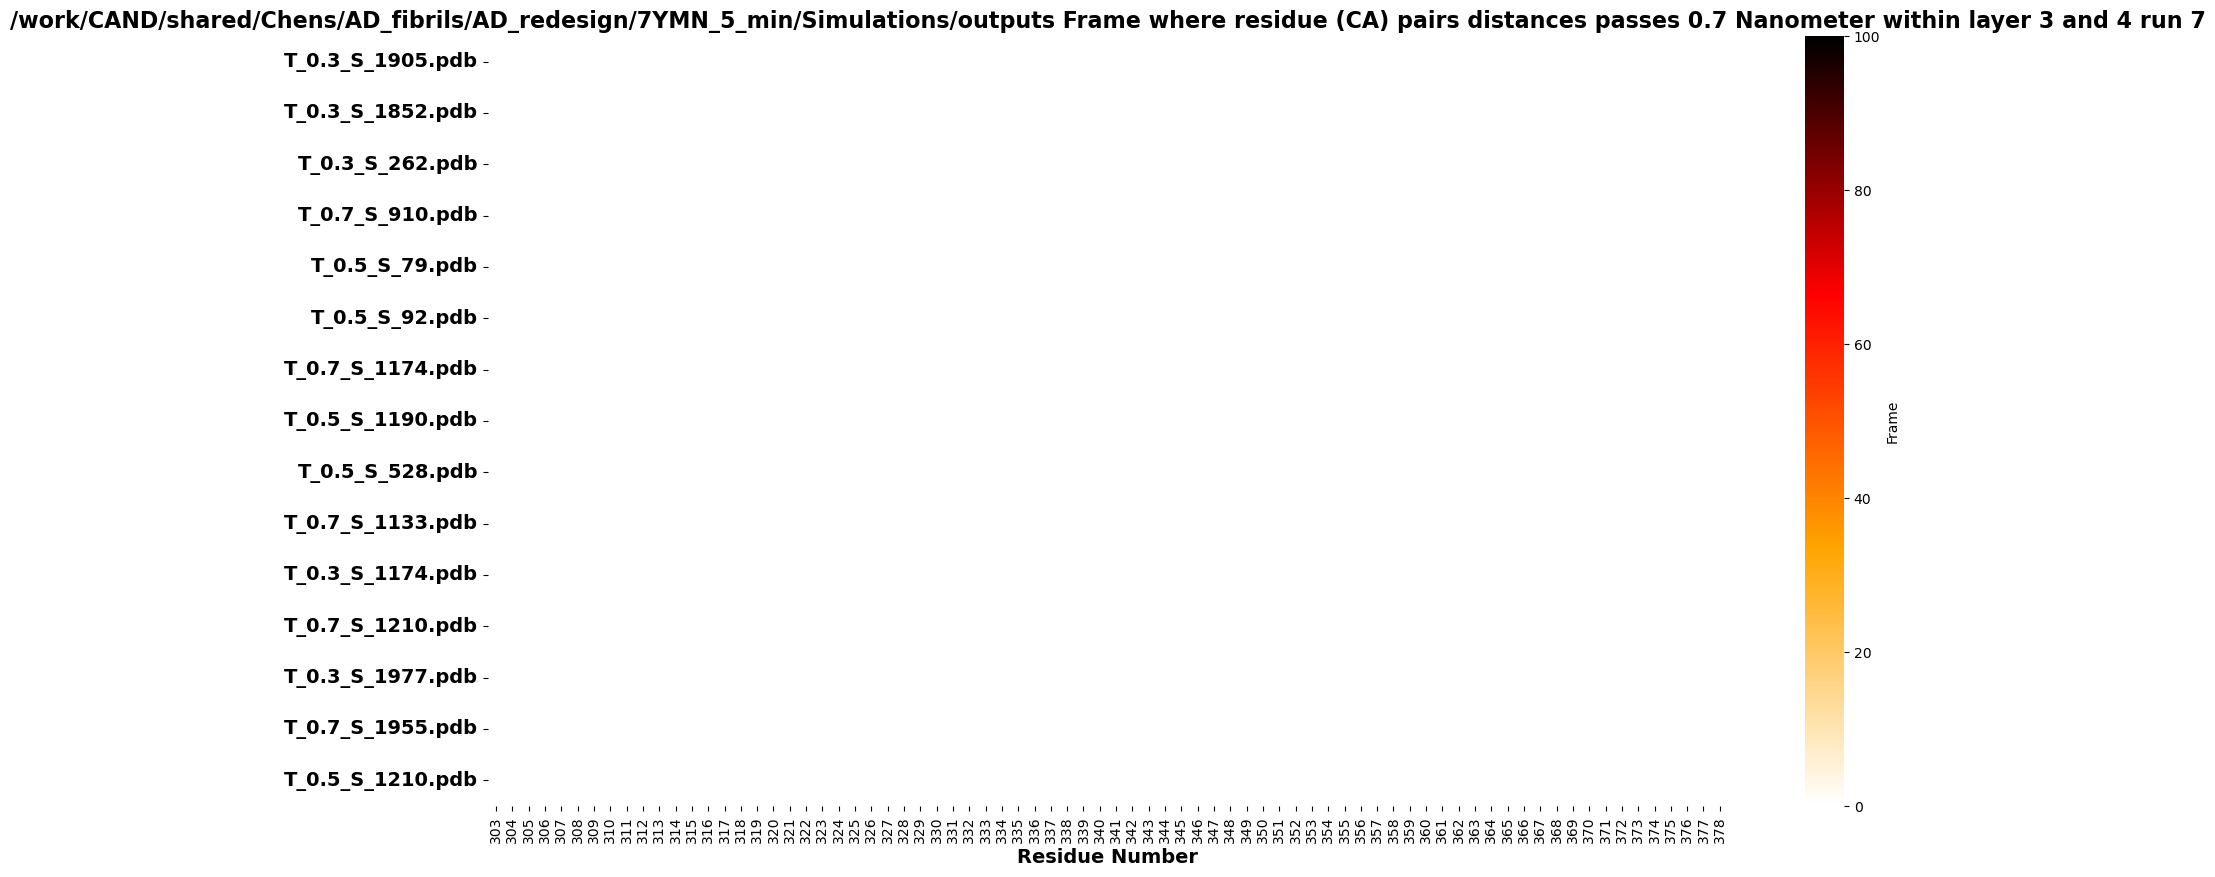

In [56]:

def AllSimulation_interlayerResiPairDistanceHeatmap(folder, simulations,proteins, run, layerA=1, distanceCutoff=5, general_protein_name='7YMN_5_min'):
    #create a sns pallete to have color for each pair
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_orange", 
                                                 ["white", "#FFA500", "red", "black"])
    proteinData = pd.DataFrame(columns = ['Residue','Protein'])
    smallesStarter = 10000
    for protein in proteins:
        starter = residuePerLayer(protein)[1]
        if starter < smallesStarter:
            smallesStarter = starter
    for colorNum, protein in enumerate(proteins):
        #create residue pairs of a protein between layers for all simulations
        tempData = pd.DataFrame(columns = ['Residue','Protein'])

        for simulation in simulations:
            #traj = mu.load_upside_traj('/work/CAND/shared/Chens/deNovoFibrils/{}/normalized_traj/{}/{}.run.{}.up'.format(folder, simulation,protein, run))
            traj = mu.load_upside_traj('{}/{}/{}.run.{}.up'.format(folder, simulation,protein, run))
            print(traj)
            #layerA = 1
            residueNumber = residuePerLayer(general_protein_name)[0]
            aligningOffset = residuePerLayer(general_protein_name)[1] - smallesStarter
            chainA = list(np.arange((layerA-1)*residueNumber,(layerA)*residueNumber))
            pairs = ((i,i+residueNumber) for i in chainA)
            pairs = list(pairs)
            atomList=[]
            for pair in pairs:
                #find the CA atoms for each residue in pair
                atomA = traj.top.select('resid {} and name CA'.format(pair[0]))
                atomB = traj.top.select('resid {} and name CA'.format(pair[1]))
                #check that atomA and atomB are not empty
                if atomA and atomB:
                    atomList.append((atomA[0], atomB[0]))
            #check size of pairs
            distanceList = md.compute_distances(traj, atomList, periodic=False)
            pairDict = {}
            for num, pair in enumerate(pairs):
                pairDict[num] = 1000
                for frame, distance in enumerate(distanceList):
                    if distance[num] > distanceCutoff:
                        pairDict[num] = frame
                        break
            #concatenate the data to parent dataframe
            #add offset to the residue number
            pairDict = {k+aligningOffset:v for k,v in pairDict.items()}
            #check if the data is empty
            if tempData.empty:
                tempData = pd.DataFrame({'Residue': list(pairDict.keys()), 'Protein':protein,simulation: list(pairDict.values())})
            else:
                tempData = pd.merge(tempData, pd.DataFrame({'Residue': list(pairDict.keys()),  'Protein':protein,simulation: list(pairDict.values())}), on=['Residue','Protein'], how='outer')
        #concatenate the data to parent dataframe
        proteinData = pd.concat([proteinData,tempData])
        print(proteinData)
    #create a new column containing the average of all the simulations
    proteinData['Frame'] = proteinData.iloc[:,2:].mean(axis=1)
    #add the starter to the residue number 
    proteinData['Residue'] = proteinData['Residue'] + smallesStarter
    #plot the dataframe in a heatmap using the different proteins as y axis and reside number as x axis
    plt.figure(figsize=(20,10))
    # Correct usage
    pivot_df = proteinData.pivot(index="Protein", columns="Residue", values="Frame")
    #divide frames by 1000 to get a percentage
    pivot_df = pivot_df/len(traj)*100
    #sort protein
    pivot_df = pivot_df.reindex(proteins)
    sns.heatmap( pivot_df, cmap=cmap, vmin=0, vmax=100, cbar_kws={'label': 'Frame'})
    #make the ticks in the heatmap bigger/bolder
    plt.yticks(fontsize=14, fontweight='bold')
    plt.ylabel('')
    #make the axis labels bigger/bolder
    plt.xlabel('Residue Number', fontsize=14, fontweight='bold')
    plt.title('{} Frame where residue (CA) pairs distances passes {} Nanometer within layer {} and {} run {}'.format(folder, distanceCutoff, layerA, layerA+1, run), fontsize=16, fontweight='bold')
#Heatmap with proteins on the y axis and the residue on x, with color indicating what percentage of time the residues between layers are within cutoff
files = os.listdir('/work/CAND/shared/Chens/AD_fibrils/AD_redesign/7YMN_5_min/top_N_fibrils')
AllSimulation_interlayerResiPairDistanceHeatmap('/work/CAND/shared/Chens/AD_fibrils/AD_redesign/7YMN_5_min/Simulations/outputs', ['Simulation1'], [file for file in files], 7, layerA=3, distanceCutoff=0.7)


In [35]:
from upsidescript_functions import normalize_fibrils_mdtraj

for files in os.listdir("/work/CAND/shared/Chens/deNovoFibrils/UpsideSimulation/Multi_TopDesigns_Annesh/outputs/Simulation1"):
    if files.endswith(".10.up"):
        traj = mu.load_upside_traj("/work/CAND/shared/Chens/deNovoFibrils/UpsideSimulation/Multi_TopDesigns_Annesh/outputs/Simulation1/{}".format(files))
        new_traj = normalize_fibrils_mdtraj(traj, ['A', 'B','C','D','E','F'])
        new_traj.save("/work/CAND/shared/Chens/deNovoFibrils/UpsideSimulation/Multi_TopDesigns_Annesh/outputs/Simulation1/{}".format(files))

Calculating the intraLayer change over all simulations

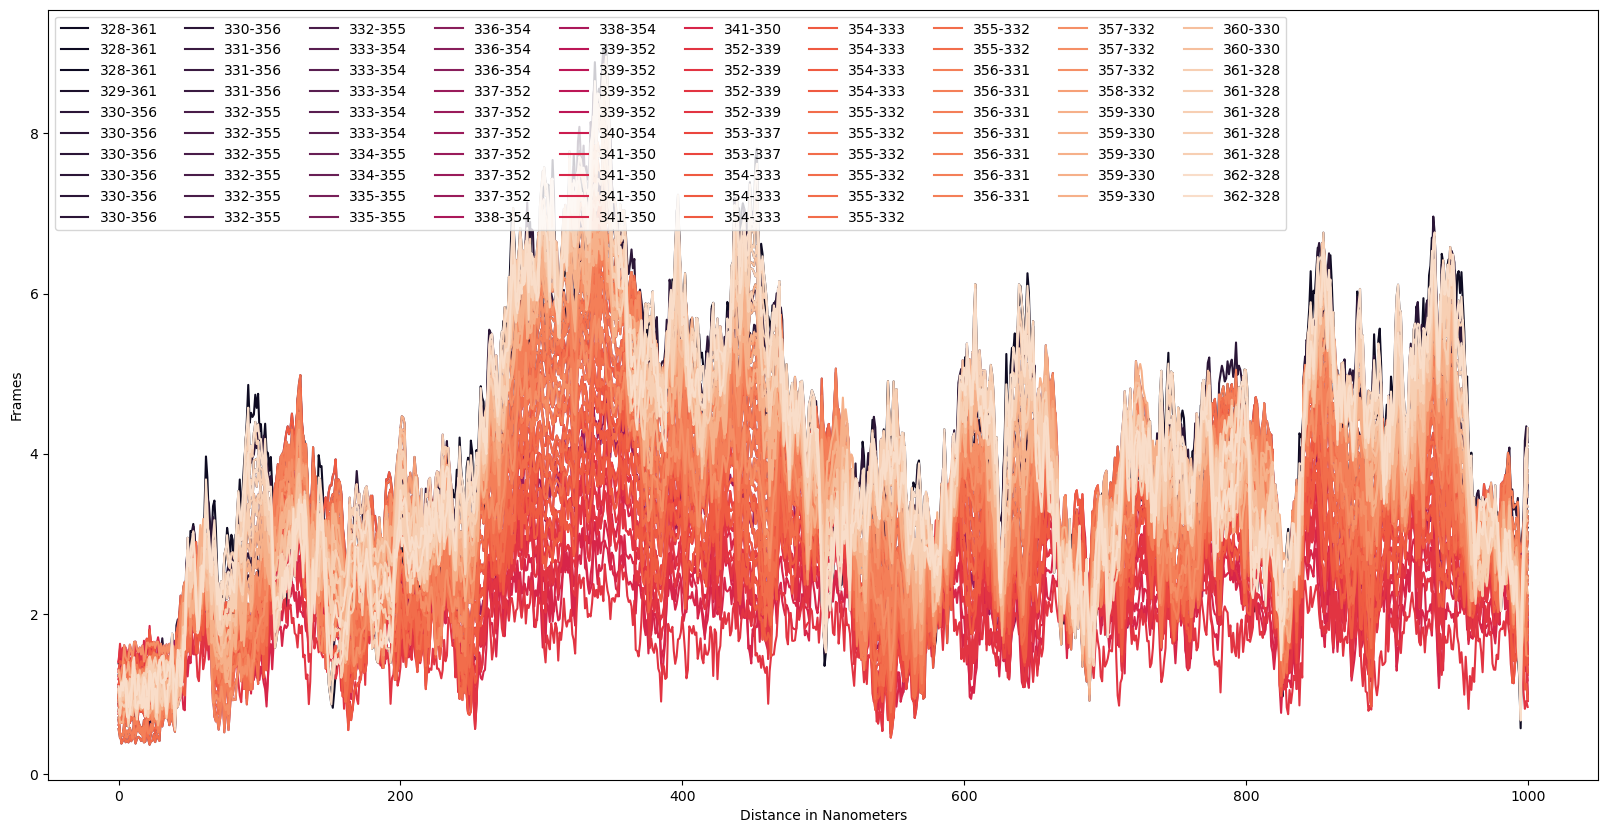

In [30]:

def AllSimulation_intraContactAnalysis(folder, simulations,proteins, run, layerA=1):
    #given a protein draw its violin plot
    #read a text file
    with open('/work/CAND/shared/Chens/betaSheetAnalysis/peptideZipperInteractions.txt', 'r') as file:
        data = file.readlines()
    plt.figure(figsize=(20,10))
    
    for protein in proteins:
        #get the starting point
        residueOffset = residuePerLayer(protein)[1]
        layerResidue = residuePerLayer(protein)[0]
        #calculate the starting point of the selected layer
        startLayer = (layerA-1)*layerResidue 
        #dictionary of pairs 
        pairs = {}
        for i in range(len(data)):
            line = data[i].split()
            if line[1] == '0':
                name = int(line[0])
                pairs[name-residueOffset+startLayer] = []
            else:
                pairs[name-residueOffset+startLayer].append(int(line[0])-residueOffset+startLayer)
        #remove all the empty ones
        pairs = {k:v for k,v in pairs.items() if v}
        #create color for all pairs
        pal = sns.color_palette("rocket", len(list(pairs)))
        for num, pair in enumerate(pairs):
            pairList = list(itertools.product([pair], pairs[pair]))
            #select the atoms
            atomList = []
            for atomPair in pairList:
                traj = mu.load_upside_traj('/work/CAND/shared/Chens/{}/outputs/{}/{}.run.{}.up'.format(folder,simulations[0],protein, run))
                atomA = traj.top.select('residue {} and name CA'.format(atomPair[0]))
                atomB = traj.top.select('residue {} and name CA'.format(atomPair[1]))
                if atomA and atomB:
                    atomList.append((atomA[0], atomB[0]))
            avgResults = 0
            for simulation in simulations:
                traj = mu.load_upside_traj('/work/CAND/shared/Chens/{}/outputs/{}/{}.run.{}.up'.format(folder,simulation,protein, run))
                #calculate distance
                distanceList = np.array(md.compute_distances(traj, atomList, periodic=False))
                avgResults = np.add(avgResults, distanceList)
            avgResults = avgResults/len(simulations)
            plt.plot(avgResults, label = '{}-{}'.format(pair+residueOffset, pairs[pair][0]+residueOffset), color = pal[num])
        plt.legend(loc='upper left', ncol=10, fontsize=10)
        plt.ylabel('Frames')
        plt.xlabel('Distance in Nanometers')
        plt.title('Intra Contact Analysis for {} run {} layer {}'.format(protein, run, layerA))    
            
AllSimulation_intraContactAnalysis('CTE-ReplicaExchange',['Simulation1'], ['CTE328-363'],7, layerA =1)


Calculate the avg RMSD across different run trials.


/work/CAND/shared/Chens/CTE-ReplicaExchange/outputs/Simulation1/CTE328-363.run.7.up
/work/CAND/shared/Chens/CTE-ReplicaExchange/outputs/Simulation2/CTE328-363.run.7.up
/work/CAND/shared/Chens/CTE-ReplicaExchange/outputs/Simulation3/CTE328-363.run.7.up


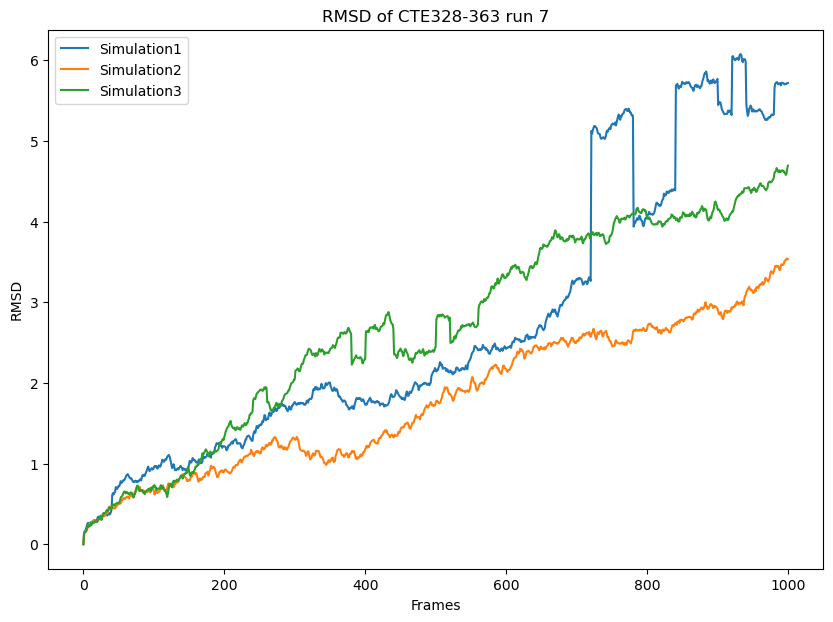

In [31]:
def RMSD(folder, simulations, protein,run):
    #calculate the RMSD of a protein
    plt.figure(figsize=(10,7))
    plt.title('RMSD of {} run {}'.format(protein, run))
    plt.ylabel('RMSD')
    plt.xlabel('Frames')
    for simulation in simulations:
        traj = mu.load_upside_traj('/work/CAND/shared/Chens/{}/outputs/{}/{}.run.{}.up'.format(folder,simulation,protein, run))
        rmsd = md.rmsd(traj, traj, 0)
        plt.plot(rmsd, label=simulation)
    plt.legend(loc='upper left')
        
RMSD('CTE-ReplicaExchange',['Simulation1','Simulation2','Simulation3'], 'CTE328-363',7)

MBAR melting curve

Failed to reach a solution to within tolerance with hybr: trying next method
/tmp/ipykernel_62815/1259725080.py:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  barplotProtein = pd.concat([barplotProtein, pd.DataFrame({'Protein': protein, 'Simulation': simulation, 'Energy': np.sum(cE0)/len(cE0)/n_rep}, index=[0])])
Failed to reach a solution to within tolerance with hybr: trying next method
Failed to reach a solution to within tolerance with hybr: trying next method
Failed to reach a solution to within tolerance with hybr: trying next method
Failed to reach a solution to within tolerance with hybr: trying next method


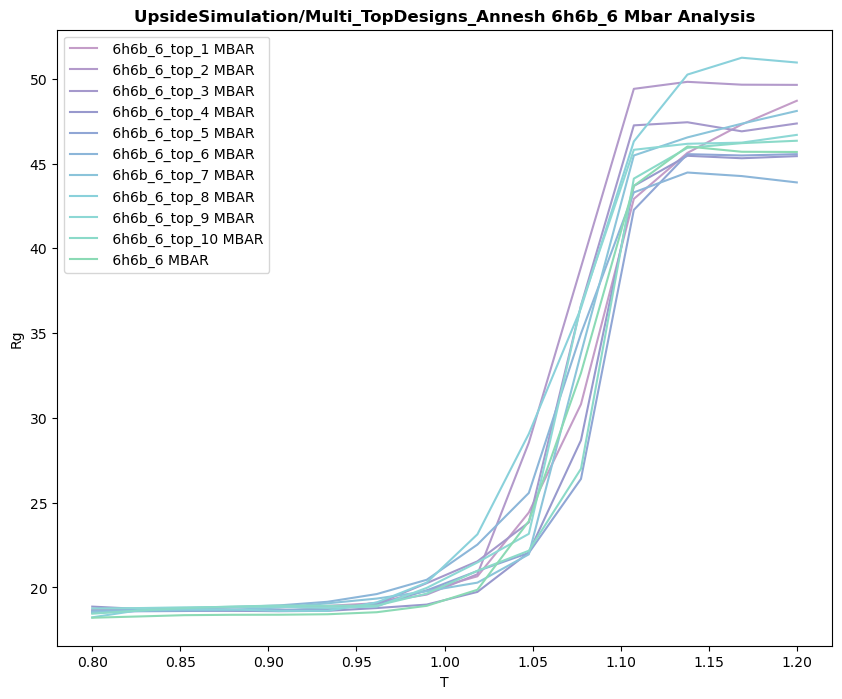

In [7]:
def mbar(folder, simulations, protein):
 
    fig1 = plt.figure(figsize=(10,8))
    #set size
    color = sns.color_palette("mako",12)
    
    barplotProtein = pd.DataFrame(columns = ['Protein', 'Simulation', 'Energy'])
    
    for num, protein in enumerate(protein):
        total_Rg_reweight = np.zeros(15)
        total_Rg_mean = np.zeros(15)
        for simulation in simulations:
            pdb_id      = protein
            sim_id      = simulation
            start_frame = 50

            work_dir         = '/work/CAND/shared/Chens/deNovoFibrils/{}'.format(folder)
            n_rep            = 15     # replica number

            input_dir  = "{}/inputs".format(work_dir)
            output_dir = "{}/outputs".format(work_dir)
            result_dir = "{}/results/{}".format(work_dir, sim_id)
            run_dir    = "{}/{}".format(output_dir, sim_id)

            #============================================
            # load data
            #============================================

            Pot = []
            Rg  = []
            Rmsd = []
            Hb = []
            Ts = []
            T  = []
            for i in range(n_rep):
                Pot.append(  np.load('{}/{}_{}_{}_Energy.npy'.format(result_dir, pdb_id, sim_id, i))[:,0] ) 
                Rg.append(   np.load('{}/{}_{}_{}_Rg.npy'    .format(result_dir, pdb_id, sim_id, i)) ) 
                Hb.append(   np.load('{}/{}_{}_{}_Hbond.npy' .format(result_dir, pdb_id, sim_id, i)) ) 
                Rmsd.append( np.load('{}/{}_{}_{}_Rmsd.npy'  .format(result_dir, pdb_id, sim_id, i)) ) 
                t = np.load( '{}/{}_{}_{}_T.npy'.format(result_dir, pdb_id, sim_id, i) )
                nsize = Pot[-1].size
                Ts.append(np.zeros(nsize) + t )
                T.append(t)
                
            Rmsd = np.array(Rmsd)
            Pot  = np.array(Pot)
            Rg   = np.array(Rg)
            Hb   = np.array(Hb)
            Ts   = np.array(Ts)
            T    = np.array(T)

            #============================================
            # mbar
            #============================================

            kB   = 1.0 # upside unit
            T    = np.array(T)
            beta = kB*T**(-1)

            cE0 = Pot[:,start_frame:]

            FN           = cE0[0].size
            FNs          = np.zeros([n_rep], np.int32) + FN
            reducedPot0  = np.zeros([n_rep,n_rep,FN], np.float32)
            for k in range(n_rep):
                for l in range(n_rep):
                    reducedPot0[k,l] = beta[l] * cE0[k]
            mbar0 = pymbar.MBAR(reducedPot0, FNs, verbose=True)

            #============================================
            # reweighting
            #============================================


            # melting cure

            Rg_mean = []
            Hb_mean = []
            Rg_reweight = []
            Hb_reweight = []

            Rg_flatten = Rg[:,start_frame:].flatten()
            Hb_flatten = Hb[:,start_frame:].flatten()

            for k in range(T.size):
                t = T[k]
                u_n = (cE0/(t*kB)).flatten()
                log_w1 = mbar0._computeUnnormalizedLogWeights(u_n)
                w1 = np.exp(log_w1)
                w1 /= np.sum(w1)

                Rg_mean.append( np.mean( Rg[k, start_frame:]) )
                Hb_mean.append( np.mean( Hb[k, start_frame:]) )
                Rg_reweight.append( np.sum( Rg_flatten * w1) )
                Hb_reweight.append( np.sum( Hb_flatten * w1) )
            barplotProtein = pd.concat([barplotProtein, pd.DataFrame({'Protein': protein, 'Simulation': simulation, 'Energy': np.sum(cE0)/len(cE0)/n_rep}, index=[0])])
                
            total_Rg_reweight += np.array(Rg_reweight)
            total_Rg_mean += np.array(Rg_mean)
        total_Rg_reweight = total_Rg_reweight/len(simulations)
        total_Rg_mean = total_Rg_mean/len(simulations)
        lighter_hls = sns.set_hls_values(color[num], l=0.7)
        darker_hls = sns.set_hls_values(color[num], l=0.3)
        # free energy along the #Hbond
        plt.plot(T, total_Rg_reweight, label=' {} MBAR'.format(protein), color=lighter_hls)
    plt.legend(loc='upper left')
    plt.xlabel('T')
    plt.ylabel('Rg')
    plt.title(f"{folder} {protein} Mbar Analysis", fontweight='bold')
    plt.show()
#mbar('AD-ReplicaExchange', ['Simulation1','Simulation2','Simulation3'], ["AD328-363", "AD328-363_S341L_S352I", "AD328-363_S356L_L357S"])
mbar('UpsideSimulation/Multi_TopDesigns_Annesh', ['Simulation1'], ["6h6b_6_top_1", "6h6b_6_top_2", "6h6b_6_top_3", "6h6b_6_top_4", "6h6b_6_top_5", "6h6b_6_top_6", "6h6b_6_top_7", "6h6b_6_top_8", "6h6b_6_top_9", "6h6b_6_top_10",'6h6b_6'])
#["CTE328-363", "CTE328-363_S341L_S352I", "CTE328-363_S356L_L357S"]


Protein Engergetics plot

Failed to reach a solution to within tolerance with hybr: trying next method
/tmp/ipykernel_64840/3465302757.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  barplotProtein = pd.concat([barplotProtein, pd.DataFrame({'Protein': protein, 'Simulation': simulation, 'Energy': np.sum(cE0)/len(cE0)/n_rep}, index=[0])])
Failed to reach a solution to within tolerance with hybr: trying next method
Failed to reach a solution to within tolerance with hybr: trying next method
Failed to reach a solution to within tolerance with hybr: trying next method
Failed to reach a solution to within tolerance with hybr: trying next method
Failed to reach a solution to within tolerance with hybr: trying next method
Failed to reach a solution to within tolerance 

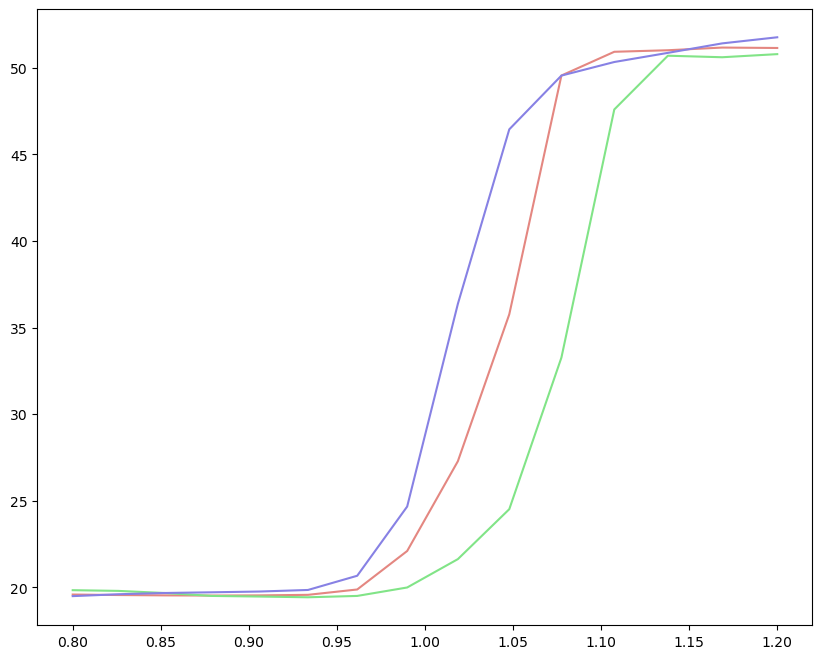

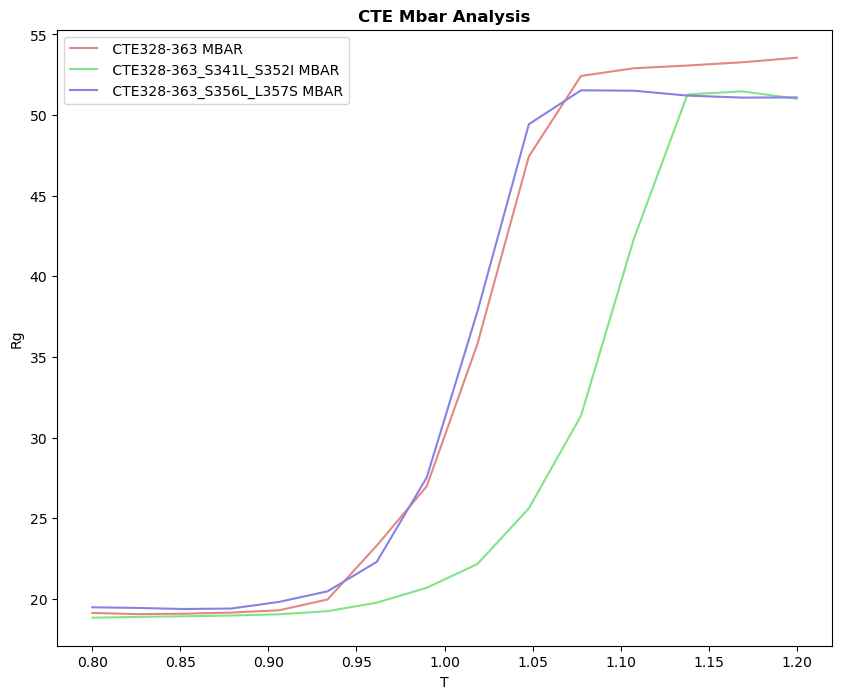

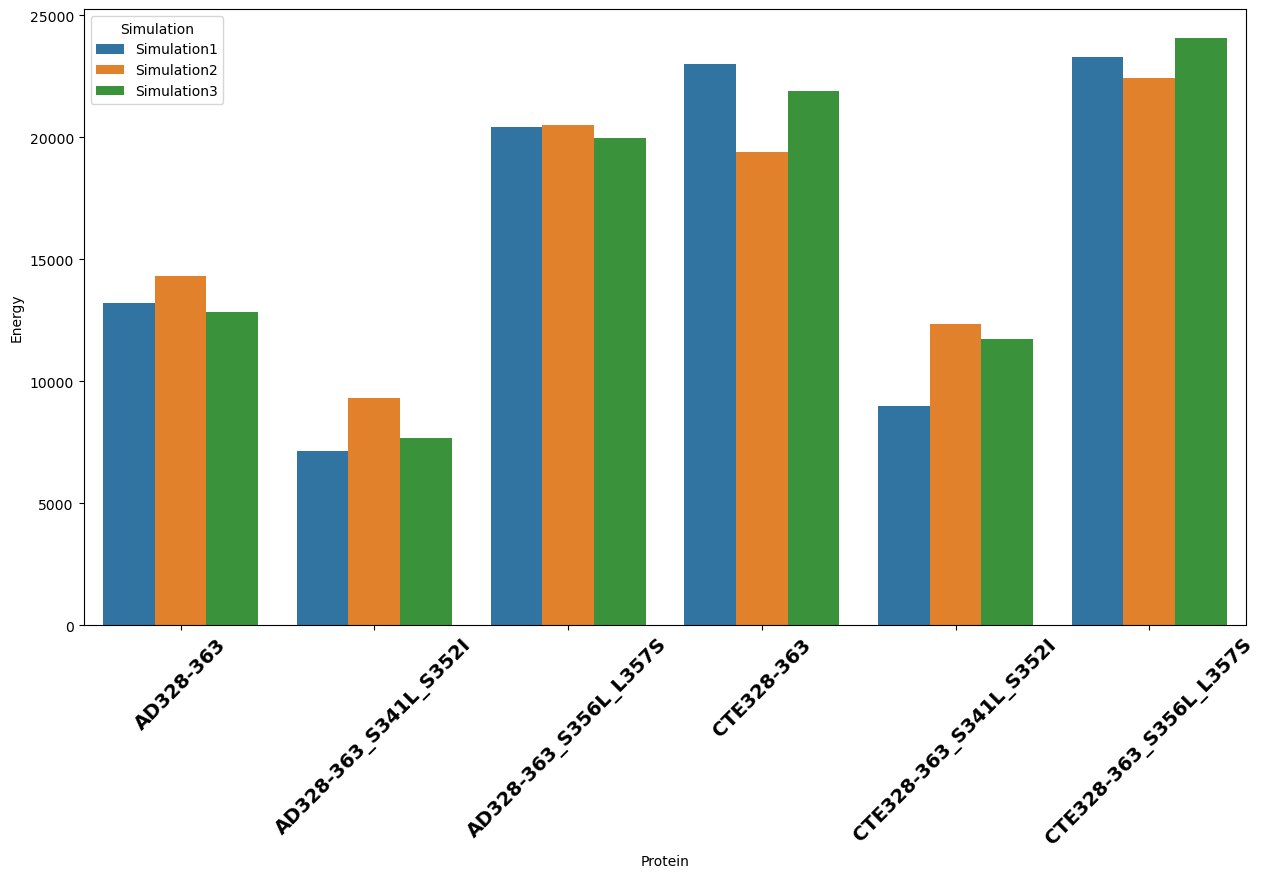

In [16]:
/work/CAND/shared/Chens/deNovoFibrils/UpsideSimulation/TopDesigns_Annesh/results/Simulation1/6h6b_6_Simulation1_0_Energy.npy
/work/CAND/shared/Chens/deNovoFibrils/UpsideSimulation/TopDesigns_UpsideMPNN/results/Simulation1/6h6b_6_Simulation1_0_Energy.npy
def mbar():
    ADsimulations = ["AD328-363", "AD328-363_S341L_S352I", "AD328-363_S356L_L357S"]
    CTEsimulations = ["CTE328-363", "CTE328-363_S341L_S352I", "CTE328-363_S356L_L357S"]
    Simulations = ["Simulation1", "Simulation2", "Simulation3"]

    fig1 = plt.figure(figsize=(10,8))
    #set size
    color = sns.color_palette("hls",len(CTEsimulations))
    
    barplotProtein = pd.DataFrame(columns = ['Protein', 'Simulation', 'Energy'])
    
    for num, protein in enumerate(ADsimulations):
        total_Rg_reweight = np.zeros(15)
        total_Rg_mean = np.zeros(15)
        for simulation in Simulations:
            pdb_id      = protein
            sim_id      = simulation
            start_frame = 50

            work_dir         = '/work/CAND/shared/Chens/AD-ReplicaExchange'
            n_rep            = 15     # replica number

            input_dir  = "{}/inputs".format(work_dir)
            output_dir = "{}/outputs".format(work_dir)
            result_dir = "{}/results/{}".format(work_dir, sim_id)
            run_dir    = "{}/{}".format(output_dir, sim_id)

            #============================================
            # load data
            #============================================

            Pot = []
            Rg  = []
            Rmsd = []
            Hb = []
            Ts = []
            T  = []
            for i in range(n_rep):
                Pot.append(  np.load('{}/{}_{}_{}_Energy.npy'.format(result_dir, pdb_id, sim_id, i))[:,0] ) 
                Rg.append(   np.load('{}/{}_{}_{}_Rg.npy'    .format(result_dir, pdb_id, sim_id, i)) ) 
                Hb.append(   np.load('{}/{}_{}_{}_Hbond.npy' .format(result_dir, pdb_id, sim_id, i)) ) 
                Rmsd.append( np.load('{}/{}_{}_{}_Rmsd.npy'  .format(result_dir, pdb_id, sim_id, i)) ) 
                t = np.load( '{}/{}_{}_{}_T.npy'.format(result_dir, pdb_id, sim_id, i) )
                nsize = Pot[-1].size
                Ts.append(np.zeros(nsize) + t )
                T.append(t)
                
            Rmsd = np.array(Rmsd)
            Pot  = np.array(Pot)
            Rg   = np.array(Rg)
            Hb   = np.array(Hb)
            Ts   = np.array(Ts)
            T    = np.array(T)

            #============================================
            # mbar
            #============================================

            kB   = 1.0 # upside unit
            T    = np.array(T)
            beta = kB*T**(-1)

            cE0 = Pot[:,start_frame:]

            FN           = cE0[0].size
            FNs          = np.zeros([n_rep], np.int32) + FN
            reducedPot0  = np.zeros([n_rep,n_rep,FN], np.float32)
            for k in range(n_rep):
                for l in range(n_rep):
                    reducedPot0[k,l] = beta[l] * cE0[k]
            mbar0 = pymbar.MBAR(reducedPot0, FNs, verbose=True)

            #============================================
            # reweighting
            #============================================


            # melting cure

            Rg_mean = []
            Hb_mean = []
            Rg_reweight = []
            Hb_reweight = []

            Rg_flatten = Rg[:,start_frame:].flatten()
            Hb_flatten = Hb[:,start_frame:].flatten()

            for k in range(T.size):
                t = T[k]
                u_n = (cE0/(t*kB)).flatten()
                log_w1 = mbar0._computeUnnormalizedLogWeights(u_n)
                w1 = np.exp(log_w1)
                w1 /= np.sum(w1)

                Rg_mean.append( np.mean( Rg[k, start_frame:]) )
                Hb_mean.append( np.mean( Hb[k, start_frame:]) )
                Rg_reweight.append( np.sum( Rg_flatten * w1) )
                Hb_reweight.append( np.sum( Hb_flatten * w1) )
            barplotProtein = pd.concat([barplotProtein, pd.DataFrame({'Protein': protein, 'Simulation': simulation, 'Energy': np.sum(cE0)/len(cE0)/n_rep}, index=[0])])
               
            total_Rg_reweight += np.array(Rg_reweight)
            total_Rg_mean += np.array(Rg_mean)
        total_Rg_reweight = total_Rg_reweight/len(ADsimulations)
        total_Rg_mean = total_Rg_mean/len(ADsimulations)
        lighter_hls = sns.set_hls_values(color[num], l=0.7)
        darker_hls = sns.set_hls_values(color[num], l=0.3)
        # free energy along the #Hbond
        plt.plot(T, total_Rg_reweight, label=' {} MBAR'.format(protein), color=lighter_hls)

        #plt.plot(T, total_Rg_mean, label='{} direct average'.format(protein), color=darker_hls)

    fig1 = plt.figure(figsize=(10,8))

    for num, protein in enumerate(CTEsimulations):
        total_Rg_reweight = np.zeros(15)
        total_Rg_mean = np.zeros(15)
        for simulation in Simulations:
            pdb_id      = protein
            sim_id      = simulation
            start_frame = 50

            work_dir         = '/work/CAND/shared/Chens/CTE-ReplicaExchange'
            n_rep            = 15     # replica number

            input_dir  = "{}/inputs".format(work_dir)
            output_dir = "{}/outputs".format(work_dir)
            result_dir = "{}/results/{}".format(work_dir, sim_id)
            run_dir    = "{}/{}".format(output_dir, sim_id)

            #============================================
            # load data
            #============================================

            Pot = []
            Rg  = []
            Rmsd = []
            Hb = []
            Ts = []
            T  = []
            for i in range(n_rep):
                Pot.append(  np.load('{}/{}_{}_{}_Energy.npy'.format(result_dir, pdb_id, sim_id, i))[:,0] ) 
                Rg.append(   np.load('{}/{}_{}_{}_Rg.npy'    .format(result_dir, pdb_id, sim_id, i)) ) 
                Hb.append(   np.load('{}/{}_{}_{}_Hbond.npy' .format(result_dir, pdb_id, sim_id, i)) ) 
                Rmsd.append( np.load('{}/{}_{}_{}_Rmsd.npy'  .format(result_dir, pdb_id, sim_id, i)) ) 
                t = np.load( '{}/{}_{}_{}_T.npy'.format(result_dir, pdb_id, sim_id, i) )
                nsize = Pot[-1].size
                Ts.append(np.zeros(nsize) + t )
                T.append(t)
                
            Rmsd = np.array(Rmsd)
            Pot  = np.array(Pot)
            Rg   = np.array(Rg)
            Hb   = np.array(Hb)
            Ts   = np.array(Ts)
            T    = np.array(T)

            #============================================
            # mbar
            #============================================

            kB   = 1.0 # upside unit
            T    = np.array(T)
            beta = kB*T**(-1)

            cE0 = Pot[:,start_frame:]

            FN           = cE0[0].size
            FNs          = np.zeros([n_rep], np.int32) + FN
            reducedPot0  = np.zeros([n_rep,n_rep,FN], np.float32)
            for k in range(n_rep):
                for l in range(n_rep):
                    reducedPot0[k,l] = beta[l] * cE0[k]
            mbar0 = pymbar.MBAR(reducedPot0, FNs, verbose=True)

            #============================================
            # reweighting
            #============================================


            # melting cure

            Rg_mean = []
            Hb_mean = []
            Rg_reweight = []
            Hb_reweight = []

            Rg_flatten = Rg[:,start_frame:].flatten()
            Hb_flatten = Hb[:,start_frame:].flatten()

            for k in range(T.size):
                t = T[k]
                u_n = (cE0/(t*kB)).flatten()
                log_w1 = mbar0._computeUnnormalizedLogWeights(u_n)
                w1 = np.exp(log_w1)
                w1 /= np.sum(w1)

                Rg_mean.append( np.mean( Rg[k, start_frame:]) )
                Hb_mean.append( np.mean( Hb[k, start_frame:]) )
                Rg_reweight.append( np.sum( Rg_flatten * w1) )
                Hb_reweight.append( np.sum( Hb_flatten * w1) )

            barplotProtein = pd.concat([barplotProtein, pd.DataFrame({'Protein': protein, 'Simulation': simulation, 'Energy': np.sum(cE0)/len(cE0)/n_rep}, index=[0])])


                
            total_Rg_reweight += np.array(Rg_reweight)
            total_Rg_mean += np.array(Rg_mean)
        total_Rg_reweight = total_Rg_reweight/len(CTEsimulations)
        total_Rg_mean = total_Rg_mean/len(CTEsimulations)
        lighter_hls = sns.set_hls_values(color[num], l=0.7)
        darker_hls = sns.set_hls_values(color[num], l=0.3)
        # free energy along the #Hbond
        plt.plot(T, total_Rg_reweight, label=' {} MBAR'.format(protein), color=lighter_hls)
        #add the corresponding proteins and energies to the dataframe

    #put legend on top left corner
    plt.legend(loc='upper left')
    plt.xlabel('T')
    plt.ylabel('Rg')

    plt.title("CTE Mbar Analysis", fontweight='bold')
    plt.show()
    #set sns plot size
    fig1 = plt.figure(figsize=(15,8))
    sns.barplot(data=barplotProtein, x='Protein', y='Energy', hue='Simulation')
    #rotate x tick
    plt.xticks(rotation=45, fontweight='bold', fontsize=14)
    

mbar()

In [ ]:
def mbar(folder, simulations, protein):
 
    fig1 = plt.figure(figsize=(10,8))
    #set size
    color = sns.color_palette("hls",len(simulations))
    
    barplotProtein = pd.DataFrame(columns = ['Protein', 'Simulation', 'Energy'])
    
    for num, protein in enumerate(protein):
        total_Rg_reweight = np.zeros(15)
        total_Rg_mean = np.zeros(15)
        for simulation in simulations:
            pdb_id      = protein
            sim_id      = simulation
            start_frame = 50

            work_dir         = '/work/CAND/shared/Chens/{}'.format(folder)
            n_rep            = 15     # replica number

            input_dir  = "{}/inputs".format(work_dir)
            output_dir = "{}/outputs".format(work_dir)
            result_dir = "{}/results/{}".format(work_dir, sim_id)
            run_dir    = "{}/{}".format(output_dir, sim_id)

            #============================================
            # load data
            #============================================

            Pot = []
            Rg  = []
            Rmsd = []
            Hb = []
            Ts = []
            T  = []
            for i in range(n_rep):
                Pot.append(  np.load('{}/{}_{}_{}_Energy.npy'.format(result_dir, pdb_id, sim_id, i))[:,0] ) 
                Rg.append(   np.load('{}/{}_{}_{}_Rg.npy'    .format(result_dir, pdb_id, sim_id, i)) ) 
                Hb.append(   np.load('{}/{}_{}_{}_Hbond.npy' .format(result_dir, pdb_id, sim_id, i)) ) 
                Rmsd.append( np.load('{}/{}_{}_{}_Rmsd.npy'  .format(result_dir, pdb_id, sim_id, i)) ) 
                t = np.load( '{}/{}_{}_{}_T.npy'.format(result_dir, pdb_id, sim_id, i) )
                nsize = Pot[-1].size
                Ts.append(np.zeros(nsize) + t )
                T.append(t)
                
            Rmsd = np.array(Rmsd)
            Pot  = np.array(Pot)
            Rg   = np.array(Rg)
            Hb   = np.array(Hb)
            Ts   = np.array(Ts)
            T    = np.array(T)

            #============================================
            # mbar
            #============================================

            kB   = 1.0 # upside unit
            T    = np.array(T)
            beta = kB*T**(-1)

            cE0 = Pot[:,start_frame:]

            FN           = cE0[0].size
            FNs          = np.zeros([n_rep], np.int32) + FN
            reducedPot0  = np.zeros([n_rep,n_rep,FN], np.float32)
            for k in range(n_rep):
                for l in range(n_rep):
                    reducedPot0[k,l] = beta[l] * cE0[k]
            mbar0 = pymbar.MBAR(reducedPot0, FNs, verbose=True)

            #============================================
            # reweighting
            #============================================


            # melting cure

            Rg_mean = []
            Hb_mean = []
            Rg_reweight = []
            Hb_reweight = []

            Rg_flatten = Rg[:,start_frame:].flatten()
            Hb_flatten = Hb[:,start_frame:].flatten()

            for k in range(T.size):
                t = T[k]
                u_n = (cE0/(t*kB)).flatten()
                log_w1 = mbar0._computeUnnormalizedLogWeights(u_n)
                w1 = np.exp(log_w1)
                w1 /= np.sum(w1)

                Rg_mean.append( np.mean( Rg[k, start_frame:]) )
                Hb_mean.append( np.mean( Hb[k, start_frame:]) )
                Rg_reweight.append( np.sum( Rg_flatten * w1) )
                Hb_reweight.append( np.sum( Hb_flatten * w1) )
            barplotProtein = pd.concat([barplotProtein, pd.DataFrame({'Protein': protein, 'Simulation': simulation, 'Energy': np.sum(cE0)/len(cE0)/n_rep}, index=[0])])
                
            total_Rg_reweight += np.array(Rg_reweight)
            total_Rg_mean += np.array(Rg_mean)
        total_Rg_reweight = total_Rg_reweight/len(simulations)
        total_Rg_mean = total_Rg_mean/len(simulations)
        lighter_hls = sns.set_hls_values(color[num], l=0.7)
        darker_hls = sns.set_hls_values(color[num], l=0.3)
        # free energy along the #Hbond
        plt.plot(T, total_Rg_reweight, label=' {} MBAR'.format(protein), color=lighter_hls)
        
mbar('AD-ReplicaExchange', ['Simulation1','Simulation2','Simulation3'], ["AD328-363", "AD328-363_S341L_S352I", "AD328-363_S356L_L357S"])
#["CTE328-363", "CTE328-363_S341L_S352I", "CTE328-363_S356L_L357S"]


Inter-Layer Interaction Video

AttributeError: 'Colorbar' object has no attribute 'get_label'

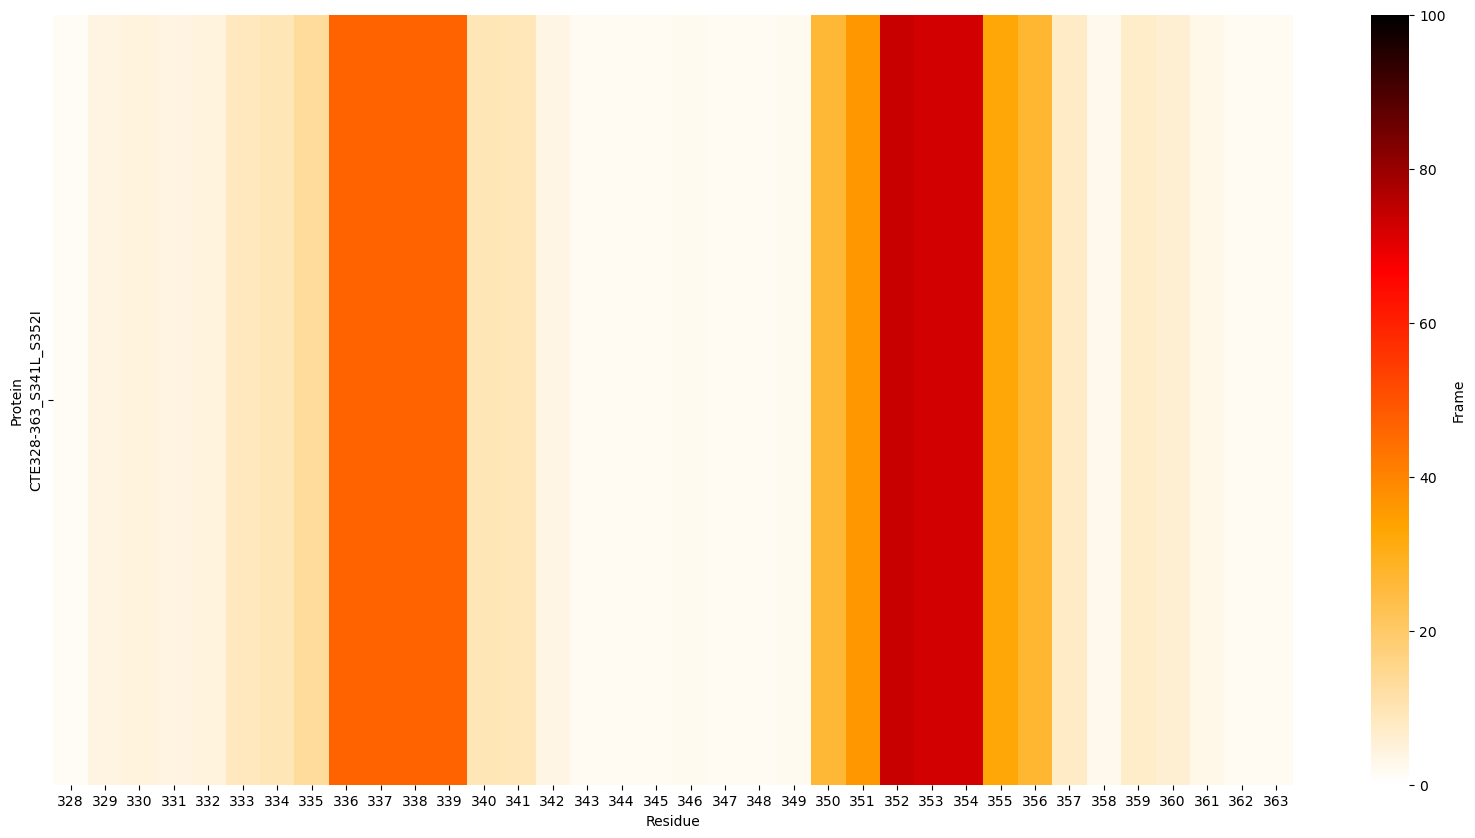

In [36]:
import matplotlib as mpl
import MDAnalysis as mda
import matplotlib

#exports the interlayer interaction data to a text file so it can be imported into a pymol and displayed onto protein
def AllSimulation_interlayerResiPairVideo(folder, simulations,proteins, run, layerA=1, distanceCutoff=5):
    #create a sns pallete to have color for each pair
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_orange", 
                                                 ["white", "#FFA500", "red", "black"])
    proteinData = pd.DataFrame(columns = ['Residue','Protein'])
    smallesStarter = 10000
    for protein in proteins:
        starter = residuePerLayer(protein)[1]
        if starter < smallesStarter:
            smallesStarter = starter
    for colorNum, protein in enumerate(proteins):
        #create residue pairs of a protein between layers for all simulations
        tempData = pd.DataFrame(columns = ['Residue','Protein'])

        for simulation in simulations:
            traj = mu.load_upside_traj('/work/CAND/shared/Chens/{}/outputs/{}/{}.run.{}.up'.format(folder, simulation,protein, run))
            #layerA = 1
            residueNumber = residuePerLayer(protein)[0]
            aligningOffset = residuePerLayer(protein)[1] - smallesStarter
            chainA = list(np.arange((layerA-1)*residueNumber,(layerA)*residueNumber))
            pairs = ((i,i+residueNumber) for i in chainA)
            pairs = list(pairs)
            atomList=[]
            for pair in pairs:
                #find the CA atoms for each residue in pair
                atomA = traj.top.select('residue {} and name CA'.format(pair[0]))
                atomB = traj.top.select('residue {} and name CA'.format(pair[1]))
                #check that atomA and atomB are not empty
                if atomA and atomB:
                    atomList.append((atomA[0], atomB[0]))
            #check size of pairs
            distanceList = md.compute_distances(traj, atomList, periodic=False)
            pairDict = {}
            for num, pair in enumerate(pairs):
                pairDict[num] = 1000
                for frame, distance in enumerate(distanceList):
                    if distance[num] > distanceCutoff:
                        pairDict[num] = frame
                        break
            #concatenate the data to parent dataframe
            #add offset to the residue number
            pairDict = {k+aligningOffset:v for k,v in pairDict.items()}
            #check if the data is empty
            if tempData.empty:
                tempData = pd.DataFrame({'Residue': list(pairDict.keys()), 'Protein':protein,simulation: list(pairDict.values())})
            else:
                tempData = pd.merge(tempData, pd.DataFrame({'Residue': list(pairDict.keys()),  'Protein':protein,simulation: list(pairDict.values())}), on=['Residue','Protein'], how='outer')
        #concatenate the data to parent dataframe
        proteinData = pd.concat([proteinData,tempData])
    #create a new column containing the average of all the simulations
    proteinData['Frame'] = proteinData.iloc[:,2:].mean(axis=1)
    #add the starter to the residue number 
    proteinData['Residue'] = proteinData['Residue'] + smallesStarter
    #plot the dataframe in a heatmap using the different proteins as y axis and reside number as x axis
    plt.figure(figsize=(20,10))
    # Correct usage
    pivot_df = proteinData.pivot(index="Protein", columns="Residue", values="Frame")
    #divide frames by 1000 to get a percentage
    pivot_df = pivot_df/len(traj)*100
    #sort protein
    pivot_df = pivot_df.reindex(proteins)
    ax = sns.heatmap(pivot_df, cmap=cmap, vmin=0, vmax=100, cbar_kws={'label': 'Frame'})

        # Make colorbar label bold
    cbar = ax.collections[0].colorbar
    cbar.set_label(cbar.get_label(), fontweight='bold')
 


    #get all the column
    columns = pivot_df.columns
    colorList = []
        # Get min and max of data
    vmin, vmax = ax.collections[0].get_clim()

    for column in columns:
        #get corresponding color in the heatmap
        data_val = pivot_df[column].values
        norm_val = (data_val - vmin) / (vmax - vmin)

        color = cmap(norm_val)
        hex_color = matplotlib.colors.rgb2hex(color)

        colorList.append(hex_color)
    print(colorList)
    return colorList
    
    # Normalize data value 

    # Get color from colormap

nums = np.arange(1, 9)
finalList = []
for num in nums:
    finalList.append(AllSimulation_interlayerResiPairVideo('CTE-ReplicaExchange',['Simulation1','Simulation2','Simulation3'], ['CTE328-363_S341L_S352I'], 7,  layerA=num, distanceCutoff=0.8))

with open("colorList.txt", 'w') as f:
    for lists in finalList:
        f.write(f"{lists}\n")




RMSD in violinplot format

In [17]:
def RMSD_ViolinPlots():
    #create violin plots comparing the RMSD protein across simulations change the following accordingly
    ADsimulations = ["AD9WT","AD328-363", "AD328-363_S341L_S352I", "AD328-363_S356L_L357S"]
    CTEsimulations = ["CTW9WT","CTE328-363", "CTE328-363_S341L_S352I", "CTE328-363_S356L_L357S"]
    Simulations = ["Simulation1", "Simulation2", "Simulation3"]
    TemperatureRun = 7

    numbers = []
    import pandas as pd
    df = pd.DataFrame(columns =["RMSD"])
    for protein in ADsimulations:
        sum = 0
        for simulation in Simulations:
            print("/work/CAND/shared/Chens/AD-ReplicaExchange/outputs/{}/{}.run.{}.up".format(simulation,protein, TemperatureRun))
            traj = mu.load_upside_traj("/work/CAND/shared/Chens/AD-ReplicaExchange/outputs/{}/{}.run.7.up".format(simulation,protein))
            sum = sum + md.rmsd(traj, traj)
        sum = sum/3
        df.loc[protein, "RMSD"] = sum
        #at tauLayer3, WTRM
    for protein in CTEsimulations:
        sum = 0
        for simulation in Simulations:
            traj = mu.load_upside_traj("/work/CAND/shared/Chens/CTE-ReplicaExchange/outputs/{}/{}.run.7.up".format(simulation,protein))
            numbers.append(md.rmsd(traj, traj))
            sum = sum + md.rmsd(traj, traj)
        sum = sum/3
        df.loc[protein, "RMSD"] = sum

    #melt the data for the violin plot
    tempdf = df.reset_index().rename(columns={"index": "Protein"})
    print(tempdf)

    rows = []
    for _, row in tempdf.iterrows():
        for rmsd_value in row['RMSD']:
            rows.append({'Class': row['Protein'],'Value': rmsd_value})

    # Create a new DataFrame from the rows
    long_df = pd.DataFrame(rows)
    print(long_df)
    #make plot bigger
    plt.figure(figsize=(10, 6))
    #make the letters vertical 
    plt.xticks(rotation=90)
    plt.yticks(rotation=90)

    #make it bold
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold', fontsize=14)

    plt.xticks(fontsize=14)
    # Now you can use seaborn to create the violin plot
    sns.violinplot(x='Class', y='Value', data=long_df)
    #set min y value
    plt.ylim(0, 6)
    plt.xlabel('')

    plt.ylabel('RMSD (nm)')
    plt.show()
RMSD_ViolinPlots()

/work/CAND/shared/Chens/AD-ReplicaExchange/outputs/Simulation1/AD9WT.run.7.up


ValueError: need at least one array to concatenate

/tmp/ipykernel_36259/472420655.py:92: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  barplot = pd.concat([barplot, pd.DataFrame({'Protein': file, 'Energy': np.sum(cE0)/len(cE0)/n_rep}, index=[0])])


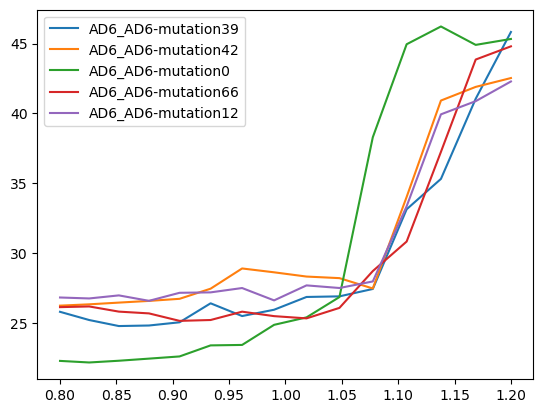

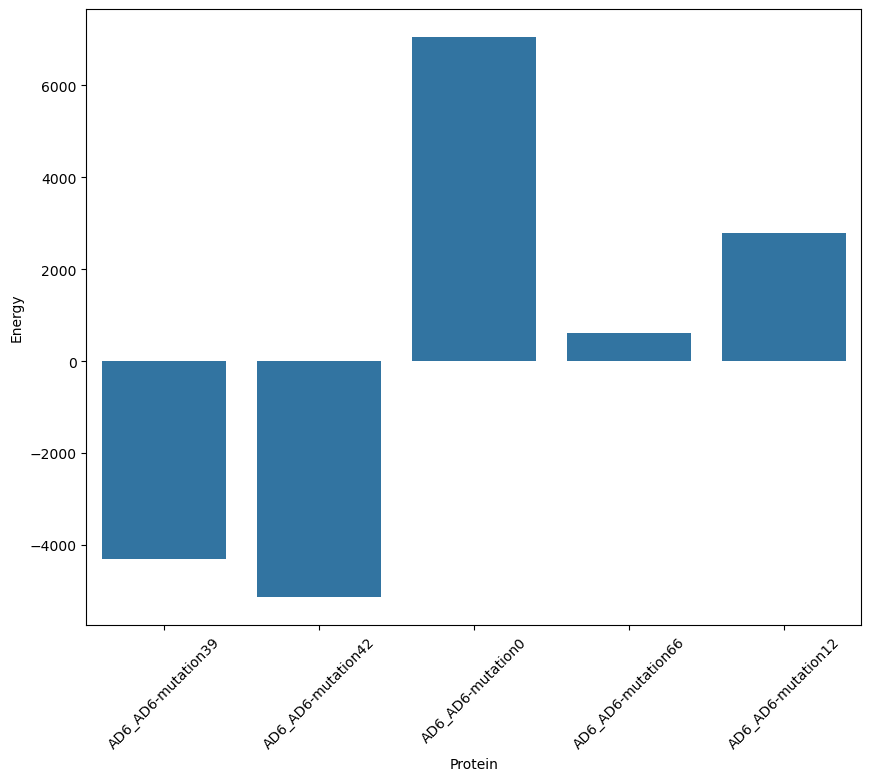

/tmp/ipykernel_36259/472420655.py:92: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  barplot = pd.concat([barplot, pd.DataFrame({'Protein': file, 'Energy': np.sum(cE0)/len(cE0)/n_rep}, index=[0])])
Failed to reach a solution to within tolerance with hybr: trying next method
Failed to reach a solution to within tolerance with hybr: trying next method
Failed to reach a solution to within tolerance with hybr: trying next method


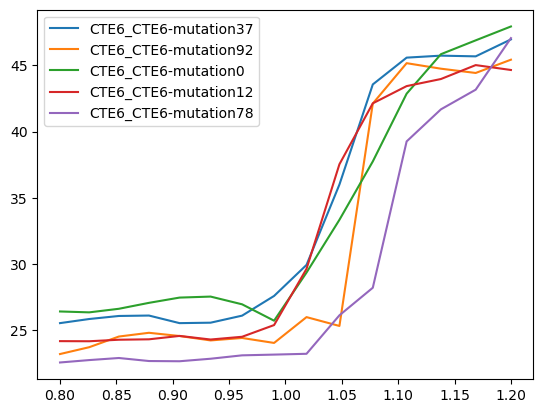

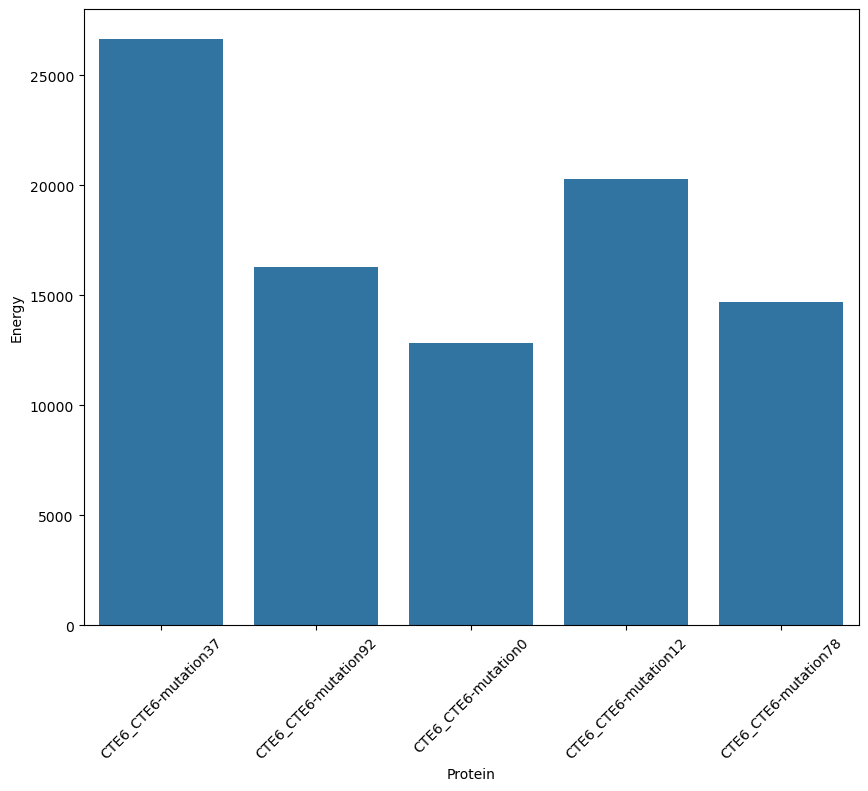

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pymbar  # for MBAR analysis
import pandas as pd
import seaborn as sns
import os

proteins=['AD6','CTE6']

for protein in proteins:
    # Specify the directory path
    directory_path = '/work/CAND/shared/Chens/proteinMPNN/upsideRun/results/{}'.format(protein)

    # List all files and directories in the specified directory
    files = os.listdir(directory_path)

    fig, ax = plt.subplots()
    barplot = pd.DataFrame(columns = ['Protein', 'Energy'])
    for file in files:
        sim_id = file
        work_dir = '/work/CAND/shared/Chens/proteinMPNN/upsideRun'
        result_dir = "{}/results/{}/{}".format(work_dir,protein, file)
        n_rep = 15  # number of replicas
        start_frame = 10
        Pot = []
        Rg  = []
        Rmsd = []
        Hb = []
        Ts = []
        T  = []
        for i in range(n_rep):
            Pot.append(  np.load('{}/{}_{}_Energy.npy'.format(result_dir, sim_id, i))[:,0] ) 
            Rg.append(   np.load('{}/{}_{}_Rg.npy'    .format(result_dir, sim_id, i)) ) 
            Hb.append(   np.load('{}/{}_{}_Hbond.npy' .format(result_dir, sim_id, i))) 
            Rmsd.append( np.load('{}/{}_{}_Rmsd.npy'  .format(result_dir, sim_id, i)) ) 
            t = np.load( '{}/{}_{}_T.npy'.format(result_dir,sim_id, i))
            nsize = Pot[-1].size
            Ts.append(np.zeros(nsize) + t )
            T.append(t)
            
        Rmsd = np.array(Rmsd)
        Pot  = np.array(Pot)
        Rg   = np.array(Rg)
        Hb   = np.array(Hb)
        Ts   = np.array(Ts)
        T    = np.array(T)

        #============================================
        # mbar
        #============================================

        kB   = 1.0 # upside unit
        T    = np.array(T)
        beta = kB*T**(-1)

        cE0 = Pot[:,start_frame:]

        FN           = cE0[0].size
        FNs          = np.zeros([n_rep], np.int32) + FN
        reducedPot0  = np.zeros([n_rep,n_rep,FN], np.float32)
        for k in range(n_rep):
            for l in range(n_rep):
                reducedPot0[k,l] = beta[l] * cE0[k]
        mbar0 = pymbar.MBAR(reducedPot0, FNs, verbose=True)

        #============================================
        # reweighting
        #============================================


        # melting cure

        Rg_mean = []
        Hb_mean = []
        Rg_reweight = []
        Hb_reweight = []

        Rg_flatten = Rg[:,start_frame:].flatten()
        Hb_flatten = Hb[:,start_frame:].flatten()

        for k in range(T.size):
            t = T[k]
            u_n = (cE0/(t*kB)).flatten()
            log_w1 = mbar0._computeUnnormalizedLogWeights(u_n)
            w1 = np.exp(log_w1)
            w1 /= np.sum(w1)

            Rg_mean.append( np.mean( Rg[k, start_frame:]) )
            Hb_mean.append( np.mean( Hb[k, start_frame:]) )
            Rg_reweight.append( np.sum( Rg_flatten * w1) )
            Hb_reweight.append( np.sum( Hb_flatten * w1) )
        barplot = pd.concat([barplot, pd.DataFrame({'Protein': file, 'Energy': np.sum(cE0)/len(cE0)/n_rep}, index=[0])])
        # Plot all the results onto a single graph
        ax.plot(T, Rg_mean, label='{}'.format(file))
    #show legend
    ax.legend()
    #plot free energy barplot
    plt.figure(figsize=(10,8))
    sns.barplot(data=barplot, x='Protein', y='Energy')
    #make barplot y label as 45 degree
    plt.xticks(rotation=45)

    """# Free energy calculation example
    fig2, ax2 = plt.subplots()
    selected_replica = 8  # Selecting a specific replica for demonstration
    ax2.plot(bc, dG_hbond[selected_replica])
    ax2.set(title=f'Free Energy Profile at T={T[selected_replica]:.2f}', xlabel='#H-bond', ylabel='Free Energy (kcal/mol)')
    """
    plt.show()


In [8]:
def mbar(Proteins, Simulations):
    
    #Simulations = ["Simulation1", "Simulation2", "Simulation3"]

    fig1 = plt.figure(figsize=(10,8))
    #set size
    color = sns.color_palette("hls",len(Proteins))
    
    barplotProtein = pd.DataFrame(columns = ['Protein', 'Simulation', 'Energy'])
    
    for num, protein in enumerate(Proteins):
        total_Rg_reweight = np.zeros(15)
        total_Rg_mean = np.zeros(15)
        for simulation in Simulations:
            pdb_id      = protein
            sim_id      = simulation
            start_frame = 50

            work_dir         = '/work/CAND/shared/Chens/proteinMPNN/upsideRun'
            n_rep            = 15     # replica number

            input_dir  = "{}/inputs".format(work_dir)
            output_dir = "{}/outputs".format(work_dir)
            result_dir = "{}/results/{}".format(work_dir, sim_id)
            run_dir    = "{}/{}".format(output_dir, sim_id)

            #============================================
            # load data
            #============================================

            Pot = []
            Rg  = []
            Rmsd = []
            Hb = []
            Ts = []
            T  = []
            for i in range(n_rep):
                Pot.append(  np.load('{}/{}/{}/{}_{}_Energy.npy'.format(result_dir, pdb_id.split('_')[0],pdb_id, pdb_id, i))[:,0] ) 
                Rg.append(   np.load('{}/{}/{}/{}_{}_Rg.npy'    .format(result_dir, pdb_id.split('_')[0],pdb_id, pdb_id, i)) ) 
                Hb.append(   np.load('{}/{}/{}/{}_{}_Hbond.npy' .format(result_dir, pdb_id.split('_')[0],pdb_id, pdb_id, i)) ) 
                Rmsd.append( np.load('{}/{}/{}/{}_{}_Rmsd.npy'  .format(result_dir, pdb_id.split('_')[0],pdb_id, pdb_id, i)) ) 
                t = np.load( '{}/{}/{}/{}_{}_T.npy'.format(result_dir, pdb_id.split('_')[0],pdb_id, pdb_id, i) )
                nsize = Pot[-1].size
                Ts.append(np.zeros(nsize) + t )
                T.append(t)
                
            Rmsd = np.array(Rmsd)
            Pot  = np.array(Pot)
            Rg   = np.array(Rg)
            Hb   = np.array(Hb)
            Ts   = np.array(Ts)
            T    = np.array(T)

            #============================================
            # mbar
            #============================================

            kB   = 1.0 # upside unit
            T    = np.array(T)
            beta = kB*T**(-1)

            cE0 = Pot[:,start_frame:]

            FN           = cE0[0].size
            FNs          = np.zeros([n_rep], np.int32) + FN
            reducedPot0  = np.zeros([n_rep,n_rep,FN], np.float32)
            for k in range(n_rep):
                for l in range(n_rep):
                    reducedPot0[k,l] = beta[l] * cE0[k]
            mbar0 = pymbar.MBAR(reducedPot0, FNs, verbose=True)

            #============================================
            # reweighting
            #============================================


            # melting cure

            Rg_mean = []
            Hb_mean = []
            Rg_reweight = []
            Hb_reweight = []

            Rg_flatten = Rg[:,start_frame:].flatten()
            Hb_flatten = Hb[:,start_frame:].flatten()

            for k in range(T.size):
                t = T[k]
                u_n = (cE0/(t*kB)).flatten()
                log_w1 = mbar0._computeUnnormalizedLogWeights(u_n)
                w1 = np.exp(log_w1)
                w1 /= np.sum(w1)

                Rg_mean.append( np.mean( Rg[k, start_frame:]) )
                Hb_mean.append( np.mean( Hb[k, start_frame:]) )
                Rg_reweight.append( np.sum( Rg_flatten * w1) )
                Hb_reweight.append( np.sum( Hb_flatten * w1) )

            barplotProtein = pd.concat([barplotProtein, pd.DataFrame({'Protein': protein, 'Simulation': simulation, 'Energy': np.sum(cE0)/len(cE0)/n_rep}, index=[0])])


                
            total_Rg_reweight += np.array(Rg_reweight)
            total_Rg_mean += np.array(Rg_mean)
        total_Rg_reweight = total_Rg_reweight/len(Proteins)
        total_Rg_mean = total_Rg_mean/len(Proteins)
        lighter_hls = sns.set_hls_values(color[num], l=0.7)
        darker_hls = sns.set_hls_values(color[num], l=0.3)
        # free energy along the #Hbond
        plt.plot(T, total_Rg_reweight, label=' {} MBAR'.format(protein), color=lighter_hls)
        #add the corresponding proteins and energies to the dataframe

    #put legend on top left corner
    plt.legend(loc='upper left')
    plt.xlabel('T')
    plt.ylabel('Rg')

    plt.title("Proteins Analysis", fontweight='bold')
    plt.show()
    #set sns plot size
    fig1 = plt.figure(figsize=(15,8))
    sns.barplot(data=barplotProtein, x='Protein', y='Energy', hue='Simulation')
    #rotate x tick
    plt.xticks(rotation=45, fontweight='bold', fontsize=14)
    
#list all the files in a directory
Proteins=['AD6','CTE6']
files=[]
for protein in Proteins:
    files = files+(os.listdir('/work/CAND/shared/Chens/proteinMPNN/upsideRun/results/Simulation1/{}'.format(protein)))
print(files)
#mbar(['AD6','CTE6'], ['Simulation1','Simulation2','Simulation3'])

TypeError: insert expected 2 arguments, got 1